# 05c Figure3 HSC diff expr

Heatmaps are for Sup Fig 5

Run with this command in docker container

docker run \
--rm \
-d \
--name scanpy2 \
-p 8880:8888 \
-e JUPYTER_ENABLE_LAB=YES \
-v /Users/efast/Documents/:/home/jovyan/work \
scanpy:1.4.6

## 1) Loading packages + data

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from gprofiler import GProfiler
import seaborn as sns; sns.set() 
from helper_functions import *

from upsetplot import UpSet
import re

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [3]:
sc.settings.set_figure_params(dpi=80, dpi_save=300, vector_friendly=True)

In [4]:
adata = sc.read(
    '/home/jovyan/work/Z_TRASH/sc_objects/LT_preprocessed.h5ad')

In [5]:
adata.var_names_make_unique()

In [6]:
adata

AnnData object with n_obs × n_vars = 15355 × 14408 
    obs: 'sample', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'Female', 'Female_cat', 'Female_str', 'sex_sample', 'batch', 'rXist', 'leiden', 'umap_density_sample'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'draw_graph', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'sex_sample_colors', 'umap', 'umap_density_sample_params'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

## Check the previous clustering (Leiden 6 clusters 25 KNN, 0.4 resolution)

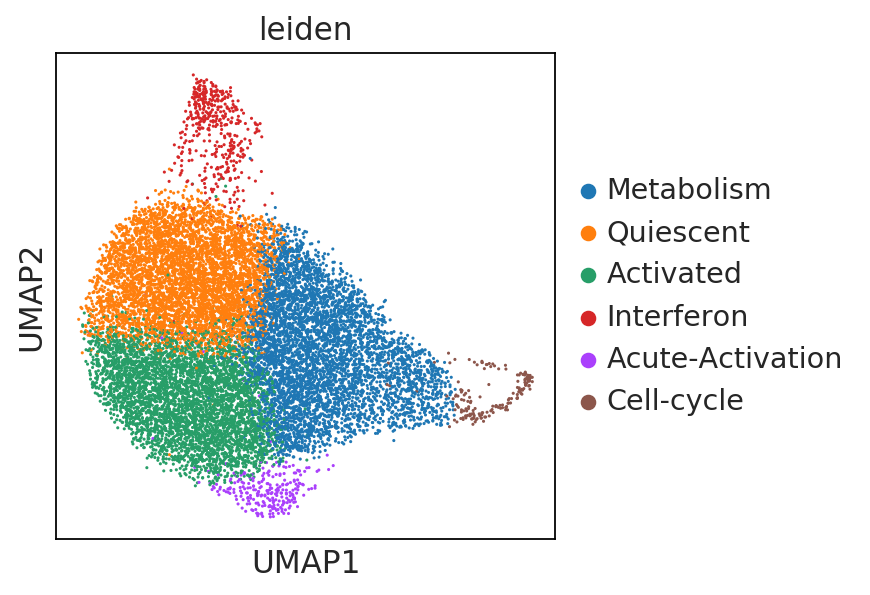

In [7]:
# rename cluster categories
adata.rename_categories('leiden', ['Metabolism', 'Quiescent', 'Activated', 
                                   'Interferon', 'Acute-Activation', 'Cell-cycle'])
sc.pl.umap(adata, color='leiden')

## Look which signatures are enriched in the different clusters

In [8]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:21)


In [9]:
# which genes are enriched in which groups
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']})
#.head(5)

pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

Metabolism Quiescent Activated Interferon Acute-Activation Cell-cycle
0        Ran     Txnip     Nr4a1      Iigp1            Cebpb      H2afz
1      Eif5a     Rps24      Hes1      Isg15          Tsc22d3      Hmgb2
2        Mif     Rplp1     H3f3b      Ifit1            Plaur      Stmn1
3        Ncl       Fau      Ier2       Gbp7           Ifngr1      Hmgb1
4       Ppia     Mllt3      Junb      Oasl2            Anks1       Ptma
5       Nme1     Rps14      Klf2     Gm4951            Fosl2      Mki67
6       Pfn1      Rpl9       Fos     Ifitm3            Rps27      H2afv
7       Ptma     Rps27     Smad7       Rtp4           Ctla2a      Cks1b
8     Anp32b     Rpl30     Nr4a2       Igtp          Tsc22d1        Ran
9    Slc25a5  Pdzk1ip1      Rgs2     Ifi203            Klf13      Spc24

In [10]:
# make new column in adata.obs for cluster sample
adata.obs['cluster_sample'] = adata.obs['sample'].str.cat(others = adata.obs['leiden'], sep='_')
adata.obs['cluster_sample']=adata.obs['cluster_sample'].astype('category', copy=True) # make a column with category as dtype

In [11]:
# Order of the lineage
lin = ('ct_Activated', 'ct_Quiescent', 'ct_Metabolism', 'ct_Interferon', 'ct_Cell-cycle',
       'pIC_Activated', 'pIC_Quiescent', 'pIC_Metabolism', 'pIC_Interferon',
       'GCSF_Activated', 'GCSF_Quiescent', 'GCSF_Metabolism', 'GCSF_Interferon',
       'dmPGE2_Activated', 'dmPGE2_Quiescent', 'dmPGE2_Metabolism', 'dmPGE2_Acute-Activation',  
       'indo_Activated', 'indo_Quiescent', 'indo_Metabolism', 'indo_Interferon',
       'GCSF_Cell-cycle', 'pIC_Cell-cycle', 'indo_Cell-cycle', 'indo_Acute-Activation',
       )

# Reordering leiden labels using Categorical data type
adata.obs['cluster_sample'] = adata.obs['cluster_sample'].cat.reorder_categories((lin), ordered=True)

In [12]:
# define colors
# only Ifn ligand that's expressed: Ifnz
# removed Ifng 'Ifngr1', 'Ifngr2'
receptors = ['Tlr3', 'Ifnar2', 'Ifnar1', 'Csf3r', 'Ptger1', 'Ptger3', 'Ptger4']
color = ['#884EA0', '#884EA0', '#884EA0', '#28B463', '#EC7063',
         '#EC7063', '#EC7063']

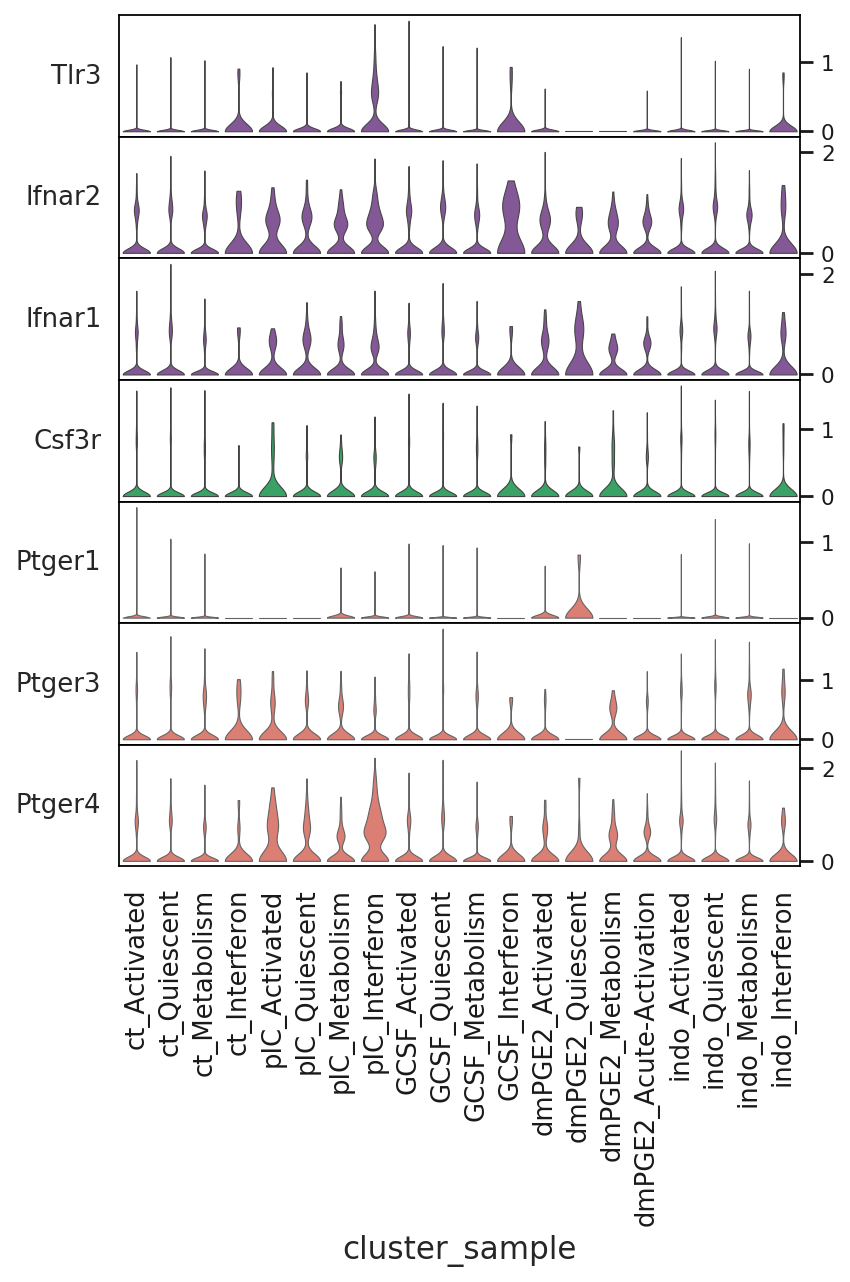

In [13]:
sc.pl.stacked_violin(adata[(adata.obs['cluster_sample']=='pIC_Activated') | (adata.obs['cluster_sample']=='ct_Activated') |
                      (adata.obs['cluster_sample']=='pIC_Quiescent') | (adata.obs['cluster_sample']=='ct_Quiescent') |
                      (adata.obs['cluster_sample']=='pIC_Metabolism') | (adata.obs['cluster_sample']=='ct_Metabolism') |
                      (adata.obs['cluster_sample']=='pIC_Interferon') | (adata.obs['cluster_sample']=='ct_Interferon') |
                      (adata.obs['cluster_sample']=='dmPGE2_Activated') | (adata.obs['cluster_sample']=='GCSF_Activated') | 
                      (adata.obs['cluster_sample']=='dmPGE2_Quiescent') | (adata.obs['cluster_sample']=='GCSF_Quiescent') | 
                      (adata.obs['cluster_sample']=='dmPGE2_Metabolism') | (adata.obs['cluster_sample']=='GCSF_Metabolism') | 
                      (adata.obs['cluster_sample']=='dmPGE2_Acute-Activation') | (adata.obs['cluster_sample']=='GCSF_Interferon') | 
                      (adata.obs['cluster_sample']=='indo_Activated') | 
                      (adata.obs['cluster_sample']=='indo_Quiescent') | 
                      (adata.obs['cluster_sample']=='indo_Metabolism') | 
                      (adata.obs['cluster_sample']=='indo_Interferon')           
                      ],
                     receptors, figsize=(6,7), log=False, swap_axes=True, save='_LT_receptors_all_groups.pdf',
                     groupby='cluster_sample', color = color)


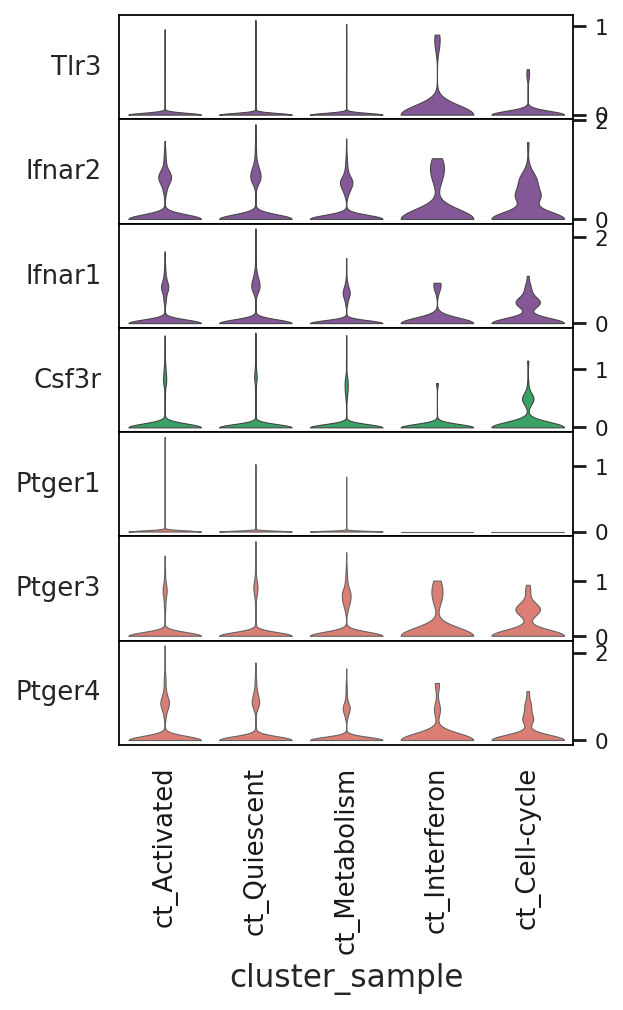

In [14]:
sc.pl.stacked_violin(adata[(adata.obs['cluster_sample']=='ct_Activated') |
                      (adata.obs['cluster_sample']=='ct_Quiescent') |
                      (adata.obs['cluster_sample']=='ct_Metabolism') |
                      (adata.obs['cluster_sample']=='ct_Interferon')  |
                      (adata.obs['cluster_sample']=='ct_Cell-cycle')
                      ],
                     receptors, figsize=(4,6), log=False, swap_axes=True, save='_LT_receptors_ct.pdf',
                     color = color, groupby='cluster_sample')

In [15]:
# lineage specfic TF expression

lin_tf = {'HSC': ['Runx1', 'Tal1','Lmo2', 'Bmi1', 'Gfi1', 'Gata2'],
                'Erythroid': ['Klf1', 'Gata1'],
              'Mega': ['Fli1', 'Nfe2',  'Gata1'],
              'Myeloid': ['Cebpa', 'Cebpa','Spi1', 'Gfi1'],
              'T-cell': [ 'Gata3', 'Runx3', 'Batf', 'Notch1', 'Zbtb7b', 'Tcf3', 'Ikzf1', 'Spi1',],
              'B-cell': ['Zbtb7a', 'Bcl11a', 'Xbp1', 'Irf4',],
              }
# len review with stu orkin https://www.sciencedirect.com/science/article/pii/S0092867408001256#fig1
# this is also good for lineage markers https://www.sciencedirect.com/science/article/pii/S1934590907002202#mmc3

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: Metabolism, Quiescent, Activated, etc.
var_group_labels: HSC, Erythroid, Mega, etc.


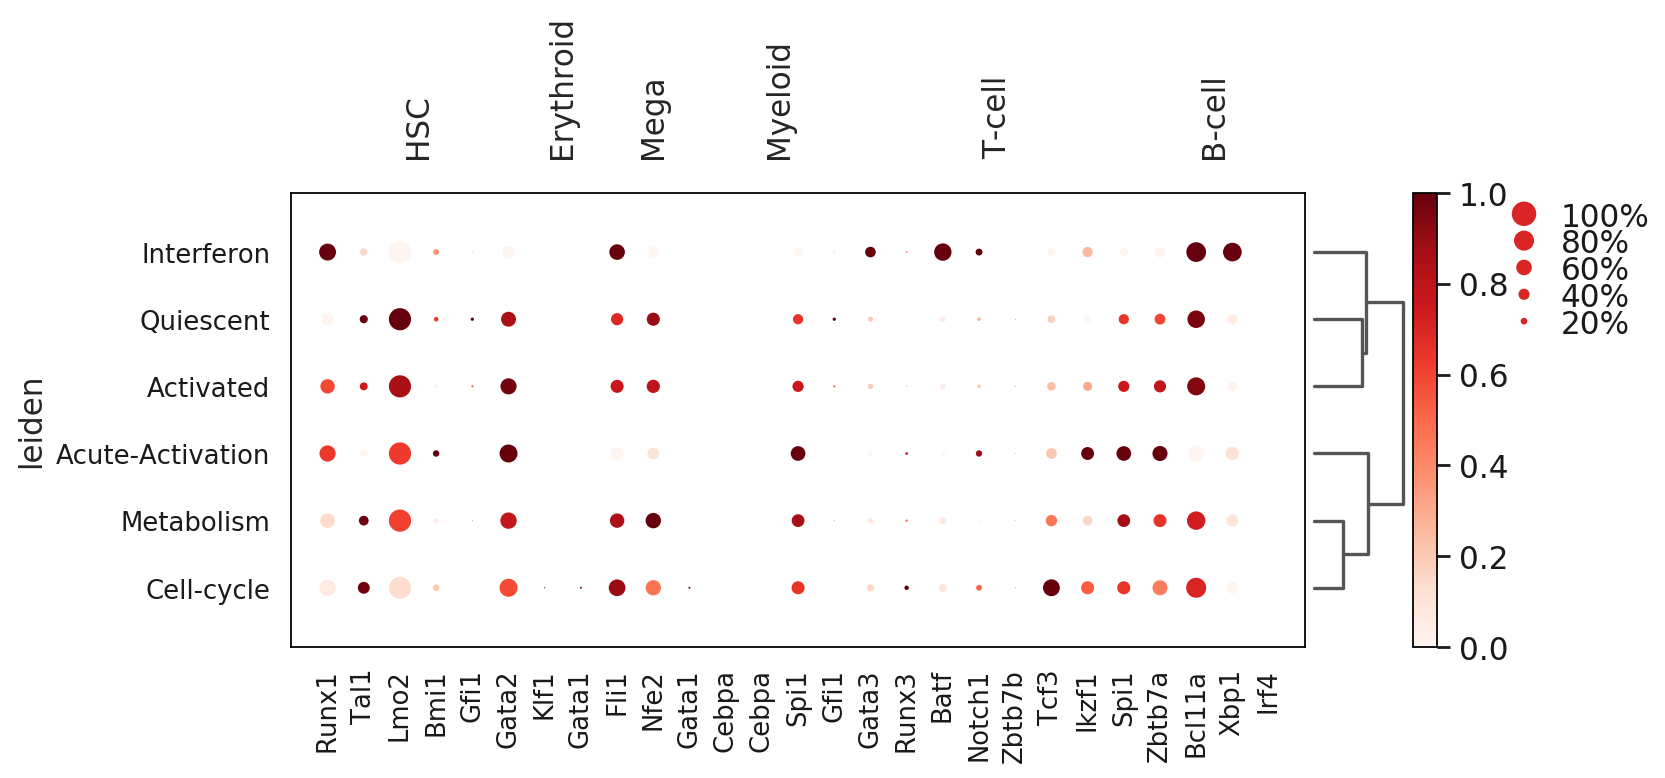

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[8.25, 0.8, 0.2, 0.5, 0.25])

In [16]:
sc.pl.dotplot(adata, lin_tf, groupby='leiden',standard_scale='var', figsize = (10, 4), save='_LT_TF_factors.pdf',
              dendrogram=True)

## pIC

In [17]:
# Read files and check how many genes there are in HSCs for each cutoff

diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/pIC_combo_HSCs_MPPs_nocutoff.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']
print('all differentially expressed genes')
print(len(diff_genes))

diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/pIC_combo_HSCs_MPPs_1.2.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']
print('differentially expressed genes 1.2 fold')
print(len(diff_genes))

diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/pIC_combo_HSCs_MPPs_1.5.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']
print('differentially expressed genes 1.5 fold')
print(len(diff_genes))

all differentially expressed genes
5701
differentially expressed genes 1.2 fold
894
differentially expressed genes 1.5 fold
240


In [18]:
# choose 1.5 fold
diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/pIC_combo_HSCs_MPPs_1.5.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']

# make dictonary from marker genes
pIC_dict = diff_genes.groupby('specific')['primerid'].apply(list).to_dict()

# calculate average expression per cluster
pIC_avg = average_expression(adata, pIC_dict, gene_symbol_key=None, partition_key='cluster_sample')

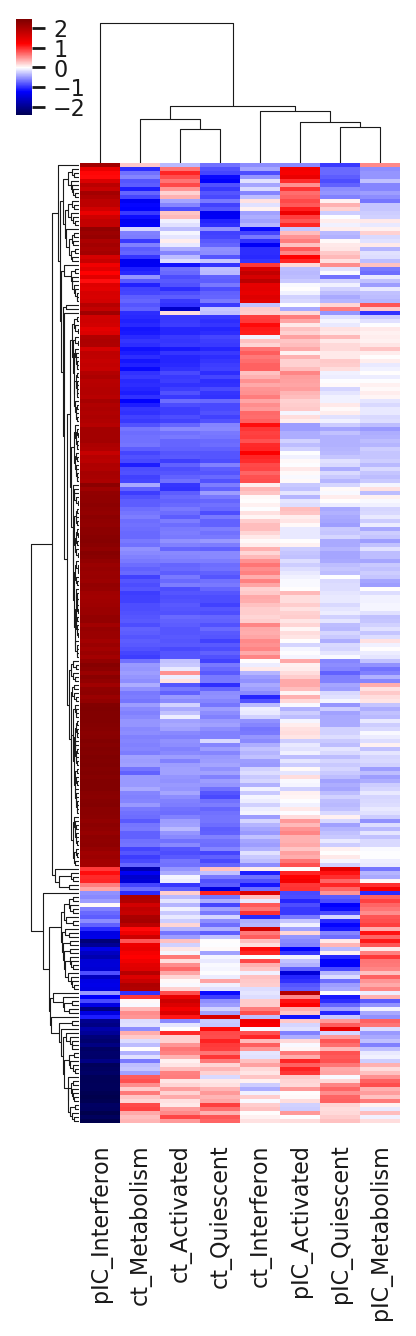

In [19]:
sns_plot = sns.clustermap(pIC_avg[['ct_Activated','ct_Quiescent','ct_Metabolism', 'ct_Interferon',
                                'pIC_Activated','pIC_Quiescent','pIC_Metabolism', 'pIC_Interferon']],
                          col_cluster=True,
                          figsize= (2, 6),
                          z_score=0,
                          method= 'average',
                          metric = 'euclidean',
                          cmap = 'seismic',
                          xticklabels=True,
                          yticklabels=False
                         )

#resize clustermap
ax_heatmap_orig_pos = sns_plot.ax_heatmap.get_position()
sns_plot.ax_heatmap.set_position([ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, 
                                  1, 1])

# resize dendrograms to match
ax_row_orig_pos = sns_plot.ax_row_dendrogram.get_position()
sns_plot.ax_row_dendrogram.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0, 
                                     ax_row_orig_pos.width, 1])
ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0 + 1,
                                     1, ax_col_orig_pos.height])


# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
sns_plot.cax.set_position([ax_heatmap_orig_pos.x0 - 0.2, ax_heatmap_orig_pos.y0 + 1.05, 
                                  .05, .1])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=10) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 5)  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 10)  # For y axis

#sns_plot.cax.set_position([1, .75, .03, .03])

#sns_plot.ax_heatmap.annotate('local max', xy=(2, 1), xytext=(3, 1.5),
           # arrowprops=dict(facecolor='black', shrink=0.05),
            #)

#plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=10) 
sns_plot.savefig("./figures/pIC_1.5_heatmap_all_genes_condensed.pdf", dpi=300)

In [20]:
# define categories and colors for plotting (make a look up table = lut)
lut = dict(zip(pIC_avg['specific'].unique(), ["black", "lightgray"]))
row_colors = pIC_avg['specific'].map(lut)

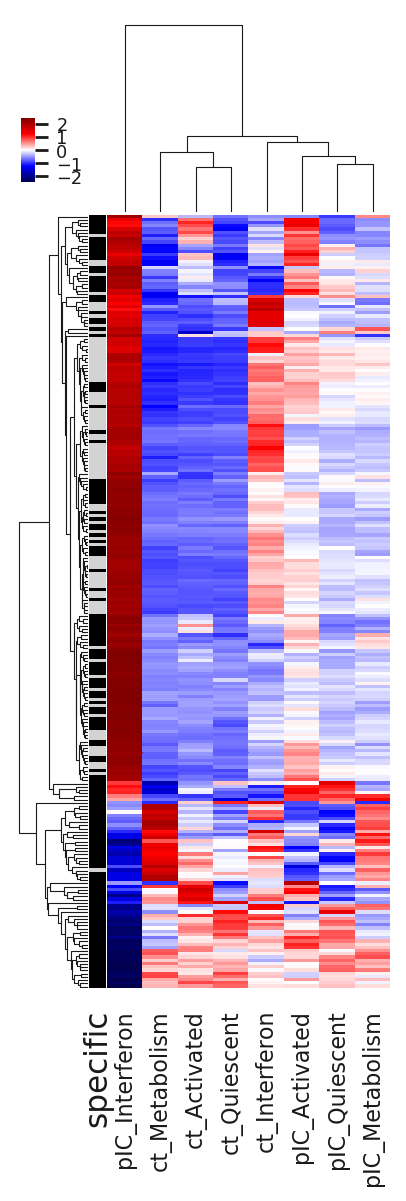

In [21]:
sns_plot = sns.clustermap(pIC_avg[['ct_Activated','ct_Quiescent','ct_Metabolism', 'ct_Interferon',
                                'pIC_Activated','pIC_Quiescent','pIC_Metabolism', 'pIC_Interferon']],
                          col_cluster=True,
                          figsize= (3, 8),
                          z_score=0,
                          method= 'average',
                          metric = 'euclidean',
                          cmap = 'seismic',
                          row_colors=row_colors,
                          xticklabels=True,
                          yticklabels=False
                         )

sns_plot.ax_row_dendrogram.set_visible(True)
sns_plot.ax_col_dendrogram.set_visible(True)


# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
sns_plot.cax.set_position([ax_heatmap_orig_pos.x0 - 0.15, ax_heatmap_orig_pos.y0 + 0.63, 
                                  .03, .05])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=8) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 5)  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 10)  # For y axis

#sns_plot.cax.set_position([1, .75, .03, .03])

#sns_plot.ax_heatmap.annotate('local max', xy=(2, 1), xytext=(3, 1.5),
           # arrowprops=dict(facecolor='black', shrink=0.05),
            #)

#plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=10) 
sns_plot.savefig("./figures/pIC_1.5_heatmap_all_genes_condensed_row_colors.pdf", dpi=300)

<Figure size 320x320 with 0 Axes>

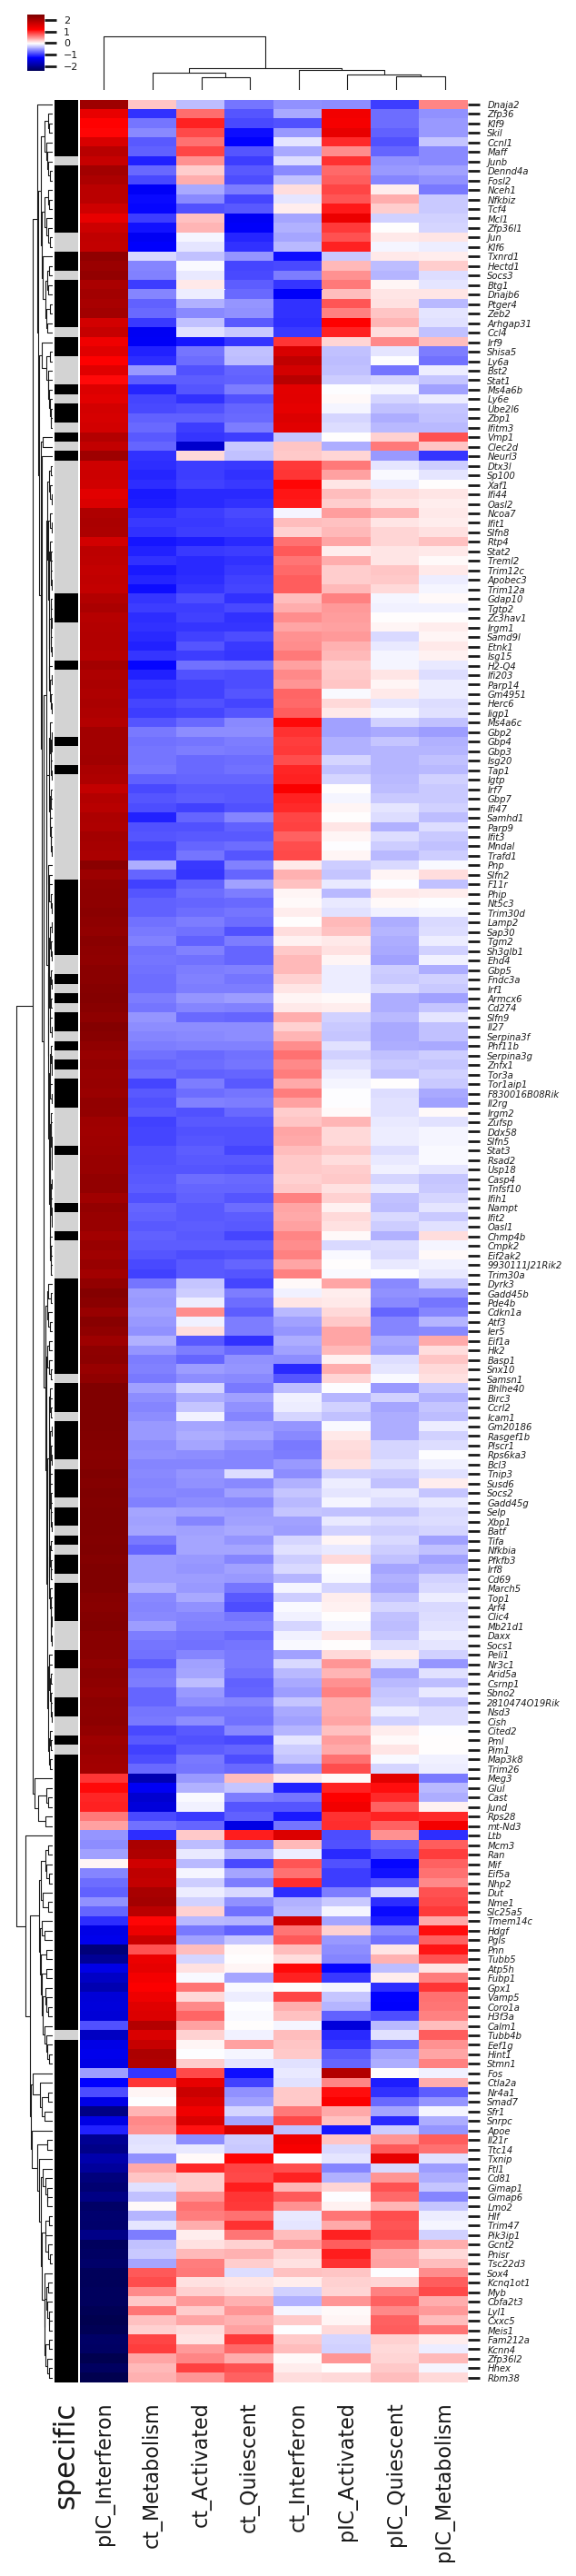

In [22]:
# larger - with gene names
plt.figure()
sns_plot = sns.clustermap(pIC_avg[['ct_Activated','ct_Quiescent','ct_Metabolism', 'ct_Interferon',
                                'pIC_Activated','pIC_Quiescent','pIC_Metabolism', 'pIC_Interferon']],
                            row_cluster=True,
                            col_cluster=True,
                            cmap = 'seismic', 
                            figsize= (4, 26),
                            row_colors=row_colors,
                            z_score=0,
                            center = 0,
                            #annot=True, 
                            yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(True)
sns_plot.ax_col_dendrogram.set_visible(True)
#sns_plot.cax.set_visible(False)

ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_col_orig_pos.y0,
                                     0.67, 0.015])

sns_plot.cax.set_position([ax_col_orig_pos.x0 - 0.09, ax_col_orig_pos.y0 + 0.005, 
                                  .03, 0.015])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=5) 


plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 4.5, style ="italic")  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 10)  # For x axis
sns_plot.savefig("./figures/pIC_1.5_heatmap_all_genes_long.pdf", dpi=300)

In [23]:
ifn_cluster = ['Oas3', 'Bst2', 'Ifitm3', 'Ube2l6']
ifn_all_response = ['Stat2', 'Irf9', 'Apobec3', 'Eif2ak2', 'Bst2', 'Ifitm3', 'Ube2l6', 'Rnf213']
specific_ifn = ['Rps6ka3', 'Nfkbia', 'Peli1', 'Map3k8']
immearly = ['Fosl2', 'Jund', 'Junb', 'Glul', 'Ptger4']
hema_list = ['Sox4', 'Myb',  'Lyl1', 'Meis1',  'Lmo2', 'Spi1']


# hema list more 'Cbfa2t3','Zfp36l2',
down = ['Myc', 'Gpx1', 'Coro1a', 'Mif', 'Eif5a', 'Apoe', 'Nr4a1']

In [24]:
# Order of the lineage
lin = ('ct_Quiescent', 'ct_Activated',  'ct_Metabolism', 'ct_Interferon', 'ct_Cell-cycle',
       'pIC_Quiescent', 'pIC_Activated', 'pIC_Metabolism', 'pIC_Cell-cycle', 'pIC_Interferon',
        'GCSF_Quiescent', 'GCSF_Activated', 'GCSF_Interferon','GCSF_Metabolism', 'GCSF_Cell-cycle', 
       'dmPGE2_Activated', 'dmPGE2_Quiescent', 'dmPGE2_Metabolism', 'dmPGE2_Acute-Activation', 
       'indo_Activated', 'indo_Quiescent', 'indo_Metabolism', 'indo_Cell-cycle', 'indo_Interferon', 'indo_Acute-Activation',
       )

# Reordering leiden labels using Categorical data type
adata.obs['cluster_sample'] = adata.obs['cluster_sample'].cat.reorder_categories((lin), ordered=True)

In [25]:
pIC_dic = {'UP general': ifn_all_response,
           'UP specific': specific_ifn,
           'DOWN specific': hema_list,
            }

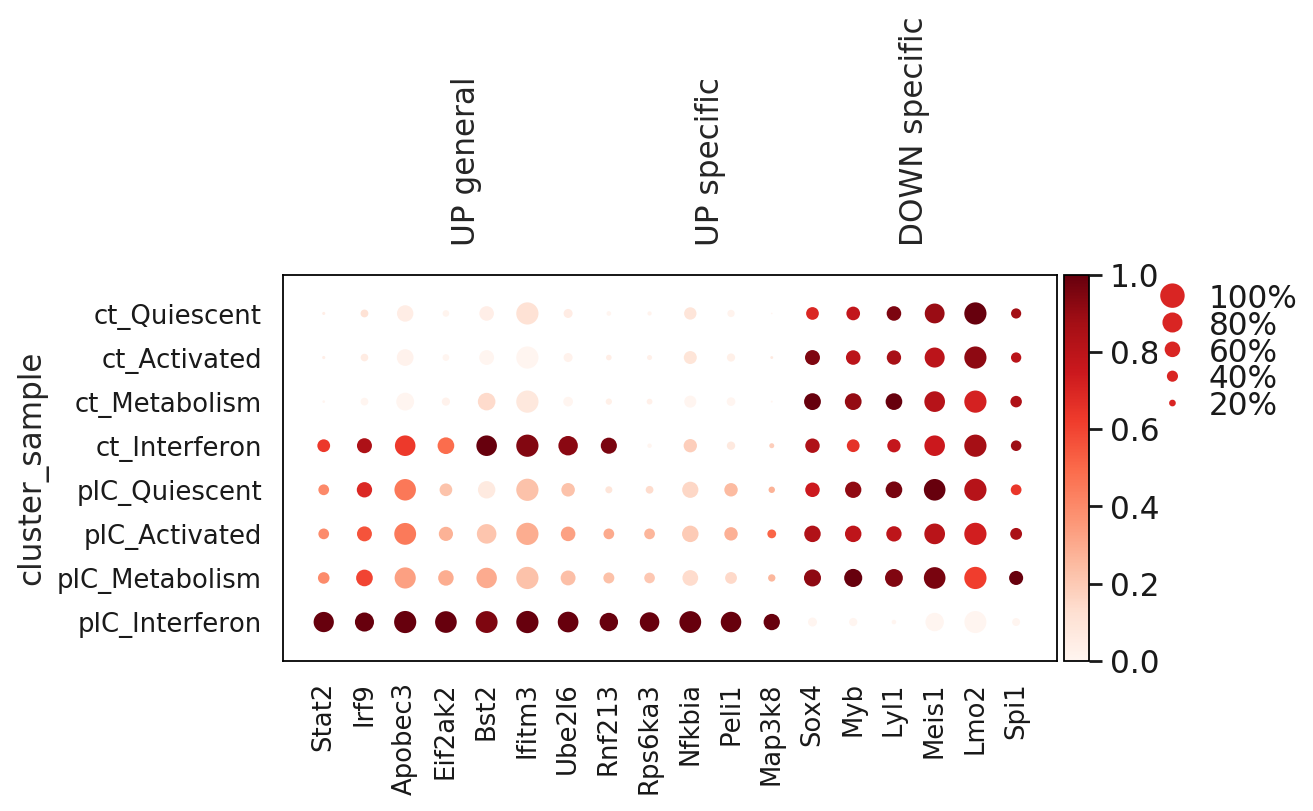

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[6.3, 0, 0.2, 0.5, 0.25])

In [26]:
sc.pl.dotplot(adata[(adata.obs['cluster_sample']=='pIC_Activated') | (adata.obs['cluster_sample']=='ct_Activated') |
                      (adata.obs['cluster_sample']=='pIC_Quiescent') | (adata.obs['cluster_sample']=='ct_Quiescent') |
                      (adata.obs['cluster_sample']=='pIC_Metabolism') | (adata.obs['cluster_sample']=='ct_Metabolism') |
                      (adata.obs['cluster_sample']=='pIC_Interferon') | (adata.obs['cluster_sample']=='ct_Interferon')
                      ],
                      pIC_dic, groupby='cluster_sample', standard_scale = 'var', save='_LT_pIC.pdf')

In [27]:
pIC_dic = {'up IFN': ifn_all_response,
           'up TLR': specific_ifn,
            }

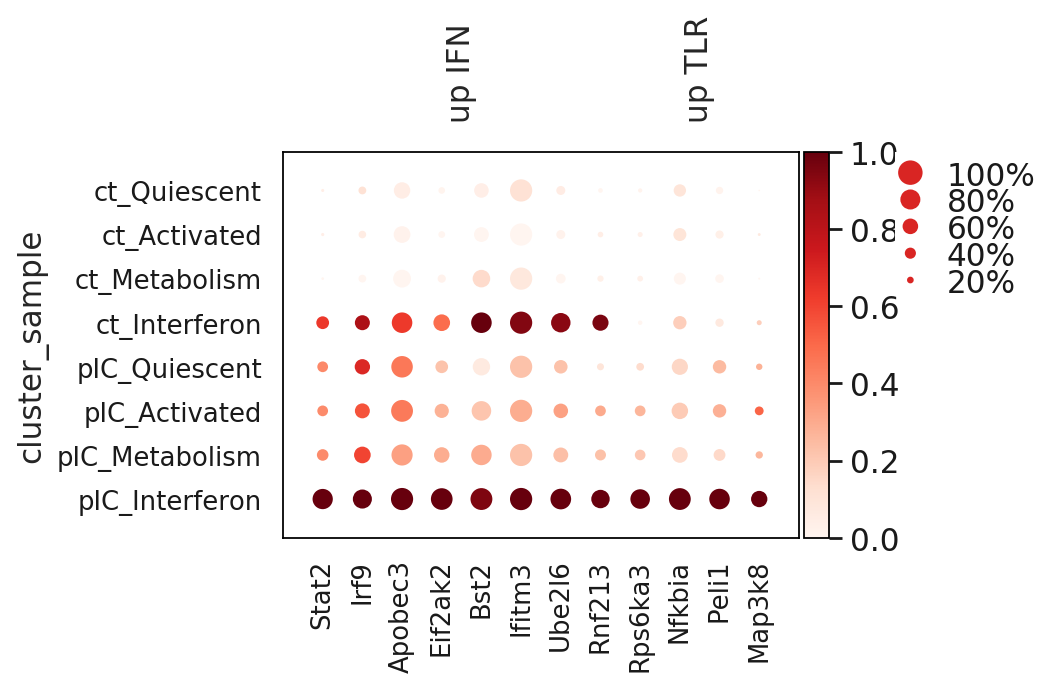

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[4.199999999999999, 0, 0.2, 0.5, 0.25])

In [28]:
sc.pl.dotplot(adata[(adata.obs['cluster_sample']=='pIC_Activated') | (adata.obs['cluster_sample']=='ct_Activated') |
                      (adata.obs['cluster_sample']=='pIC_Quiescent') | (adata.obs['cluster_sample']=='ct_Quiescent') |
                      (adata.obs['cluster_sample']=='pIC_Metabolism') | (adata.obs['cluster_sample']=='ct_Metabolism') |
                      (adata.obs['cluster_sample']=='pIC_Interferon') | (adata.obs['cluster_sample']=='ct_Interferon')
                      ],
                      pIC_dic, groupby='cluster_sample', standard_scale = 'var', save='_LT_pIC_new.pdf')

## GCSF

In [29]:
# Read files and check how many genes there are in HSCs for each cutoff

diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/GCSF_combo_HSCs_MPPs_nocutoff.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']
print('all differentially expressed genes')
print(len(diff_genes))

diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/GCSF_combo_HSCs_MPPs_1.2.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']
print('differentially expressed genes 1.2 fold')
print(len(diff_genes))

diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/GCSF_combo_HSCs_MPPs_1.5.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']
print('differentially expressed genes 1.5 fold')
print(len(diff_genes))

all differentially expressed genes
5025
differentially expressed genes 1.2 fold
320
differentially expressed genes 1.5 fold
19


In [30]:
# choose 1.2 fold
diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/GCSF_combo_HSCs_MPPs_1.2.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']

# make dictonary from marker genes
GCSF_dict = diff_genes.groupby('specific')['primerid'].apply(list).to_dict()

# calculate average expression per cluster
GCSF_avg = average_expression(adata, GCSF_dict, gene_symbol_key=None, partition_key='cluster_sample')

In [31]:
# define categories and colors for plotting (make a look up table = lut)
lut = dict(zip(GCSF_avg['specific'].unique(), ["black", "lightgray"]))
row_colors = GCSF_avg['specific'].map(lut)

<Figure size 320x320 with 0 Axes>

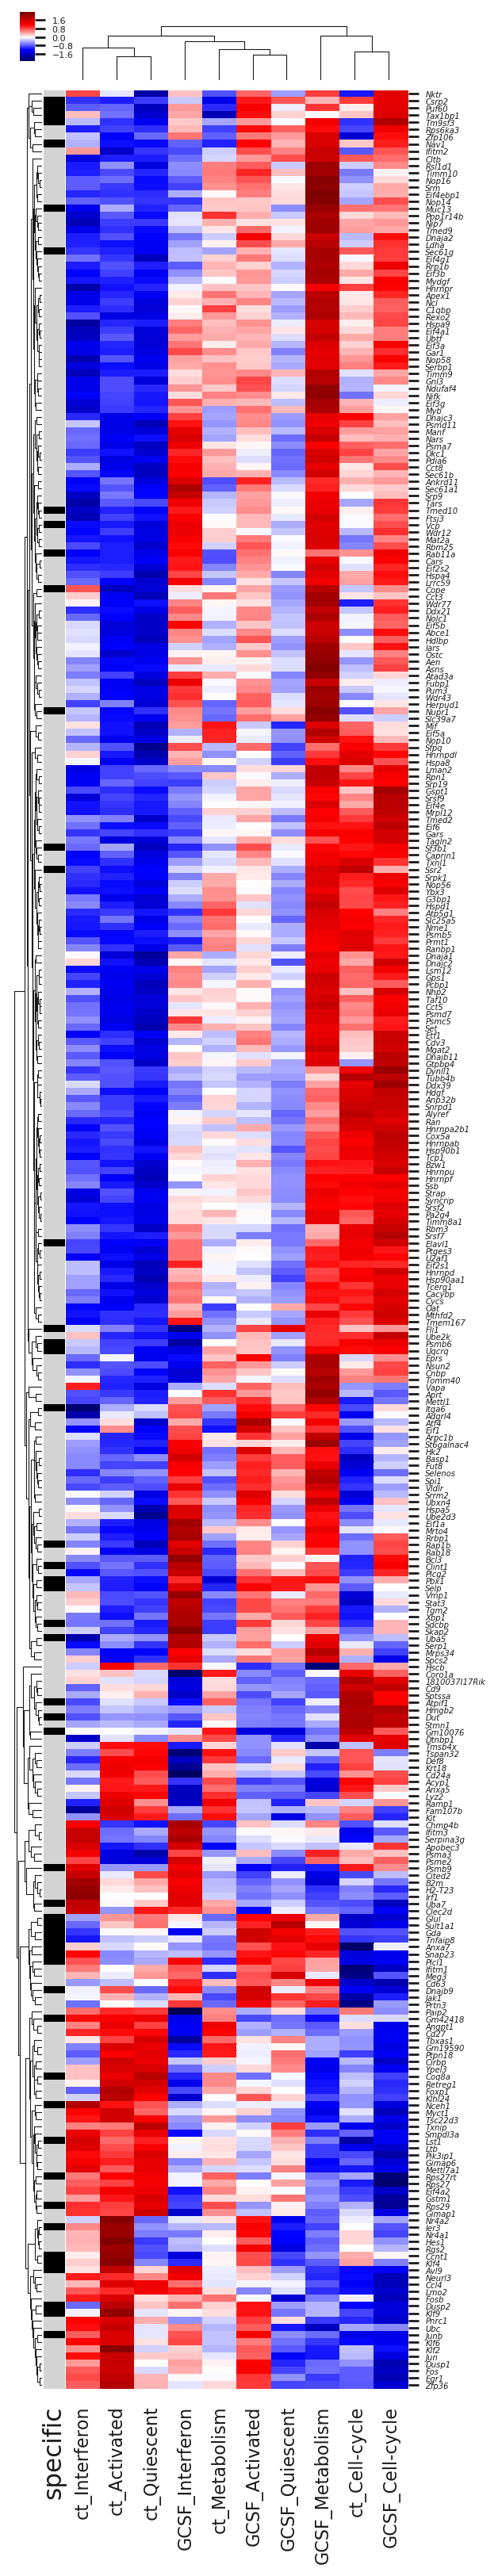

In [32]:
# larger - with gene names
plt.figure()
sns_plot = sns.clustermap(GCSF_avg[['ct_Activated','ct_Quiescent','ct_Metabolism', 'ct_Interferon', 'ct_Cell-cycle',
                                'GCSF_Activated','GCSF_Quiescent','GCSF_Metabolism', 'GCSF_Interferon', 'GCSF_Cell-cycle']],
                            row_cluster=True,
                            col_cluster=True,
                            cmap = 'seismic', 
                            figsize= (4, 30),
                            row_colors=row_colors,
                            z_score=0,
                            center = 0,
                            #annot=True, 
                            yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(True)
sns_plot.ax_col_dendrogram.set_visible(True)
#sns_plot.cax.set_visible(False)

ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_col_orig_pos.y0,
                                     0.67, 0.015])

sns_plot.cax.set_position([ax_col_orig_pos.x0 - 0.09, ax_col_orig_pos.y0 + 0.005, 
                                  .03, 0.013])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=5) 


plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 4.5, style ="italic")  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 10)  # For y axis
sns_plot.savefig("/home/jovyan/work/Z_TRASH/figures/GCSF_1.2_heatmap_all_genes_long.pdf", dpi=300)

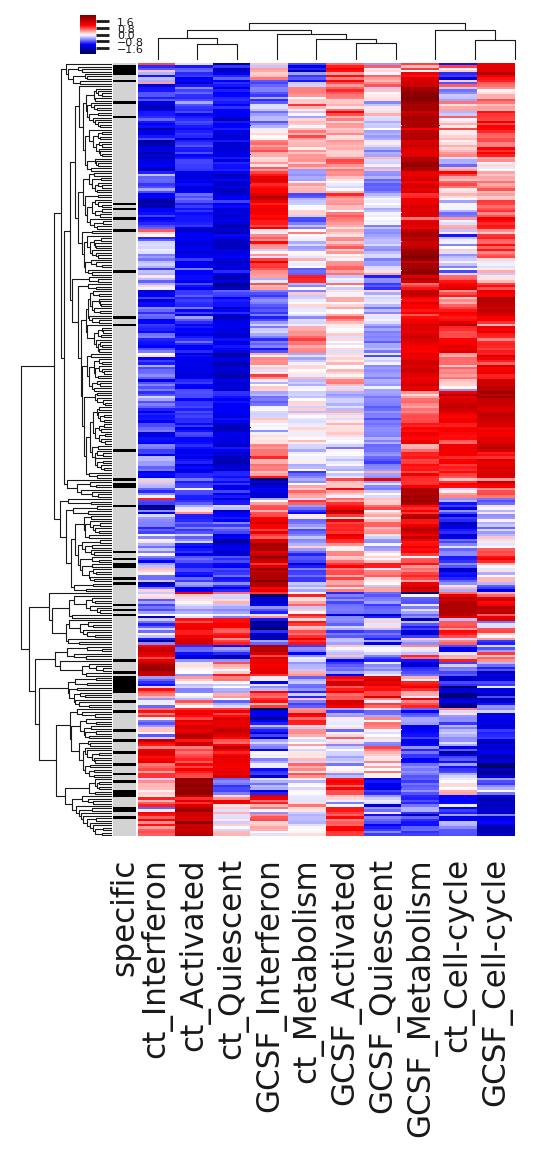

In [33]:
sns_plot = sns.clustermap(GCSF_avg[['ct_Activated','ct_Quiescent','ct_Metabolism', 'ct_Interferon', 'ct_Cell-cycle',
                                'GCSF_Activated','GCSF_Quiescent','GCSF_Metabolism', 'GCSF_Interferon', 'GCSF_Cell-cycle']],
                                  col_cluster=True,
                                  figsize= (4, 8),
                                  z_score=0,
                                  yticklabels=False,
                                  row_colors=row_colors,
                                  cmap = 'seismic')


sns_plot.ax_row_dendrogram.set_visible(True)
sns_plot.ax_col_dendrogram.set_visible(True)
#sns_plot.cax.set_visible(False)


ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_col_orig_pos.y0,
                                     0.62, 0.03])

sns_plot.cax.set_position([ax_col_orig_pos.x0 - 0.09, ax_col_orig_pos.y0 + 0.005, 
                                  .025, .03])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=5)


#plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=12) 
#plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 12)  # For y axis
sns_plot.savefig("/home/jovyan/work/Z_TRASH/figures/GCSF_1.2_heatmap_all_genes_condensed_row_colors.pdf", dpi=300)

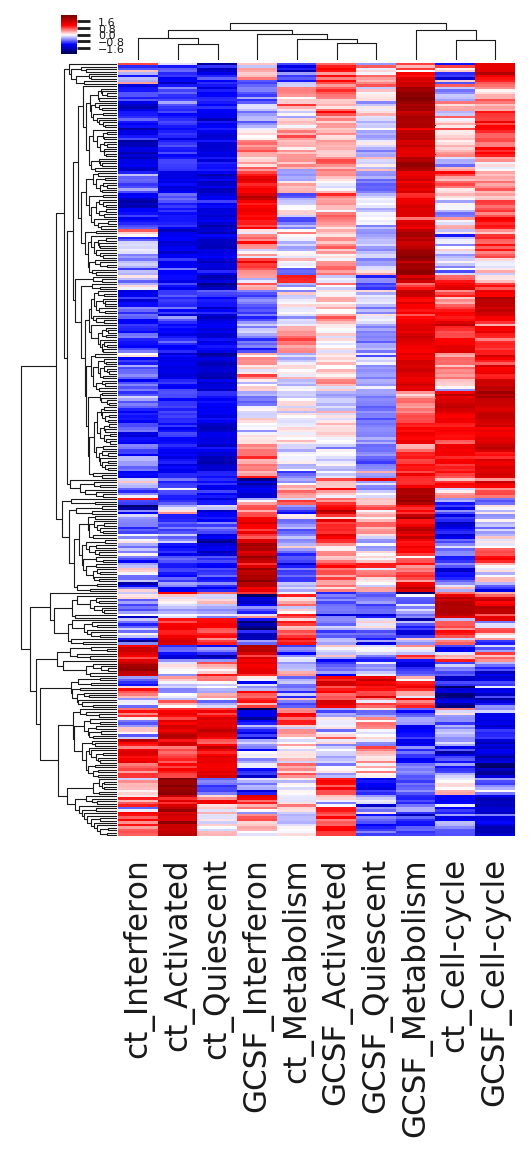

In [34]:
sns_plot = sns.clustermap(GCSF_avg[['ct_Activated','ct_Quiescent','ct_Metabolism', 'ct_Interferon', 'ct_Cell-cycle',
                                'GCSF_Activated','GCSF_Quiescent','GCSF_Metabolism', 'GCSF_Interferon', 'GCSF_Cell-cycle']],
                                  col_cluster=True,
                                  figsize= (4, 8),
                                  z_score=0,
                                  yticklabels=False,
                                  cmap = 'seismic')


sns_plot.ax_row_dendrogram.set_visible(True)
sns_plot.ax_col_dendrogram.set_visible(True)
#sns_plot.cax.set_visible(False)


ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_col_orig_pos.y0,
                                     0.62, 0.03])

sns_plot.cax.set_position([ax_col_orig_pos.x0 - 0.09, ax_col_orig_pos.y0 + 0.005, 
                                  .025, .03])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=5)


#plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=12) 
#plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 12)  # For y axis
sns_plot.savefig("/home/jovyan/work/Z_TRASH/figures/GCSF_1.2_heatmap_all_genes_condensed.pdf", dpi=300)

In [35]:
gen = ['Stat3', 'Plcg2', 'Spi1', 'Selp']
rib = [
 'Nop14',
 'Nip7',
 'Wdr43',
 'Wdr12']
tranl = ['Eif4ebp1', 'Eif4ebp2', 'Eif4a1', 'Eif4a2', 'Eif4g1', 'Eif3a', 'Eif3b', 'Eif3g']
splic = ['Srsf7', 'Srsf2', 'Sf3b1', 'Puf60']
hsp = ['Hspa5',
 'Dnajc2',
 'Dnaja1',
 'Hsp90aa1',
 'Hspd1']
rna = ['Hnrnpa2b1', 'Hnrnpf' , 'Hnrnpd']

In [36]:
GCSF_dic = {'general induction': gen,
            'ribosome biogenesis genes': rib,
           'translation initiation': tranl,
           'RNA processing': rna,
           'Splicing' :splic
            }

In [37]:
# Order of the lineage
lin = ('ct_Quiescent', 'ct_Activated', 'ct_Interferon', 'ct_Metabolism', 'ct_Cell-cycle',
       'pIC_Quiescent', 'pIC_Activated', 'pIC_Interferon', 'pIC_Metabolism', 'pIC_Cell-cycle',
        'GCSF_Quiescent', 'GCSF_Activated', 'GCSF_Interferon','GCSF_Metabolism', 'GCSF_Cell-cycle', 
       'dmPGE2_Activated', 'dmPGE2_Quiescent', 'dmPGE2_Metabolism', 'dmPGE2_Acute-Activation', 
       'indo_Activated', 'indo_Quiescent', 'indo_Metabolism', 'indo_Cell-cycle', 'indo_Interferon', 'indo_Acute-Activation',
       )

# Reordering leiden labels using Categorical data type
adata.obs['cluster_sample'] = adata.obs['cluster_sample'].cat.reorder_categories((lin), ordered=True)

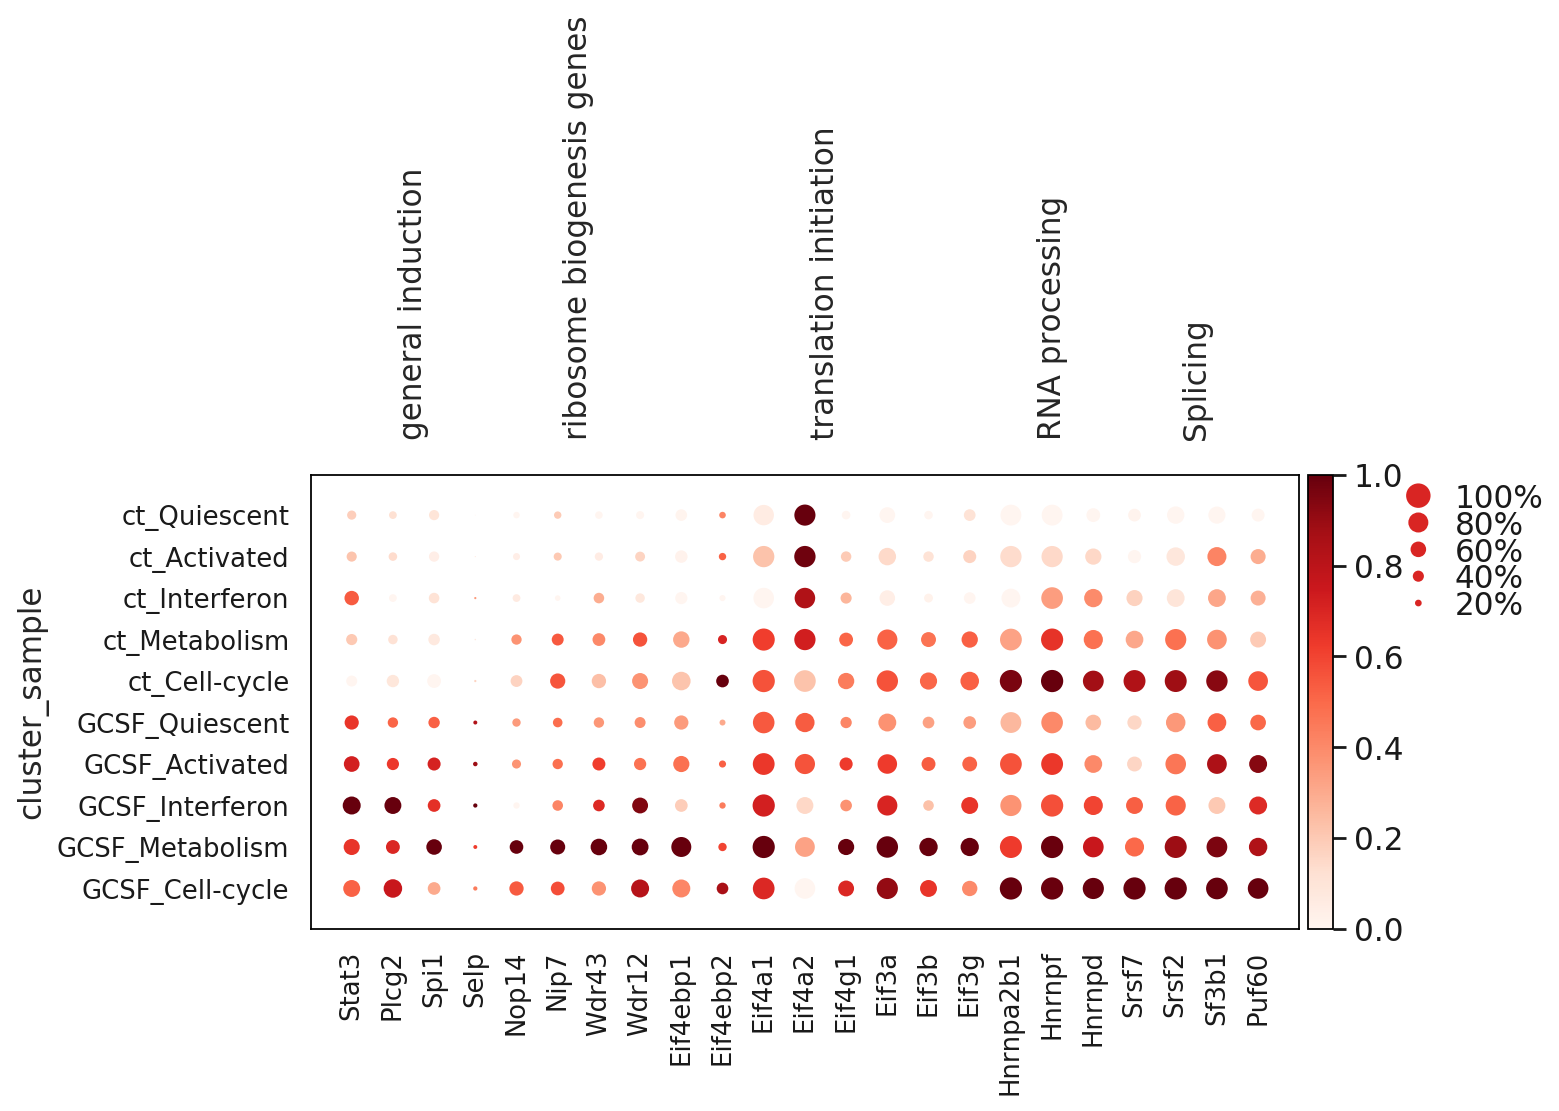

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[8.049999999999999, 0, 0.2, 0.5, 0.25])

In [38]:
sc.pl.dotplot(adata[(adata.obs['cluster_sample']=='GCSF_Activated') | (adata.obs['cluster_sample']=='ct_Activated') |
                      (adata.obs['cluster_sample']=='GCSF_Quiescent') | (adata.obs['cluster_sample']=='ct_Quiescent') |
                      (adata.obs['cluster_sample']=='GCSF_Metabolism') | (adata.obs['cluster_sample']=='ct_Metabolism') |
                      (adata.obs['cluster_sample']=='GCSF_Interferon') | (adata.obs['cluster_sample']=='ct_Interferon') |
                      (adata.obs['cluster_sample']=='ct_Cell-cycle') | (adata.obs['cluster_sample']=='GCSF_Cell-cycle')
                      ], 
                     GCSF_dic, groupby='cluster_sample', standard_scale = 'var', save='_LT_GCSF.pdf')

In [39]:
gen = ['Stat3', 'Plcg2', 'Spi1', 'Selp']
tranl = [
 'Nop14',
 'Nip7',
 'Wdr43',
 'Wdr12',
'Eif4ebp1', 'Eif4a1']
cellc = ['Srsf7', 'Srsf2', 'Sf3b1', 'Hnrnpf' , 'Hnrnpd']
splic = ['Srsf7', 'Srsf2', 'Sf3b1', 'Puf60']
hsp = ['Hspa5',
 'Dnajc2',
 'Dnaja1',
 'Hsp90aa1',
 'Hspd1']
rna = ['Hnrnpa2b1', 'Hnrnpf' , 'Hnrnpd']
down = ['Kit', 'Cd9']

In [40]:
GCSF_dic = {'general up': gen,
            'general down': down,
            'translation': tranl,
            'transcription': cellc
            }

In [41]:
GCSF_dic = {'transcription': cellc,
            'translation': tranl,
            }

In [42]:
# Order of the lineage
lin = ('ct_Quiescent', 'ct_Activated', 'ct_Interferon', 
        'GCSF_Quiescent', 'GCSF_Activated',
       'ct_Metabolism', 'ct_Cell-cycle',
       'pIC_Quiescent', 'pIC_Activated', 'pIC_Interferon', 'pIC_Metabolism', 'pIC_Cell-cycle',
        'GCSF_Interferon','GCSF_Metabolism', 'GCSF_Cell-cycle', 
       'dmPGE2_Activated', 'dmPGE2_Quiescent', 'dmPGE2_Metabolism', 'dmPGE2_Acute-Activation', 
       'indo_Activated', 'indo_Quiescent', 'indo_Metabolism', 'indo_Cell-cycle', 'indo_Interferon', 'indo_Acute-Activation',
       )

# Reordering leiden labels using Categorical data type
adata.obs['cluster_sample'] = adata.obs['cluster_sample'].cat.reorder_categories((lin), ordered=True)

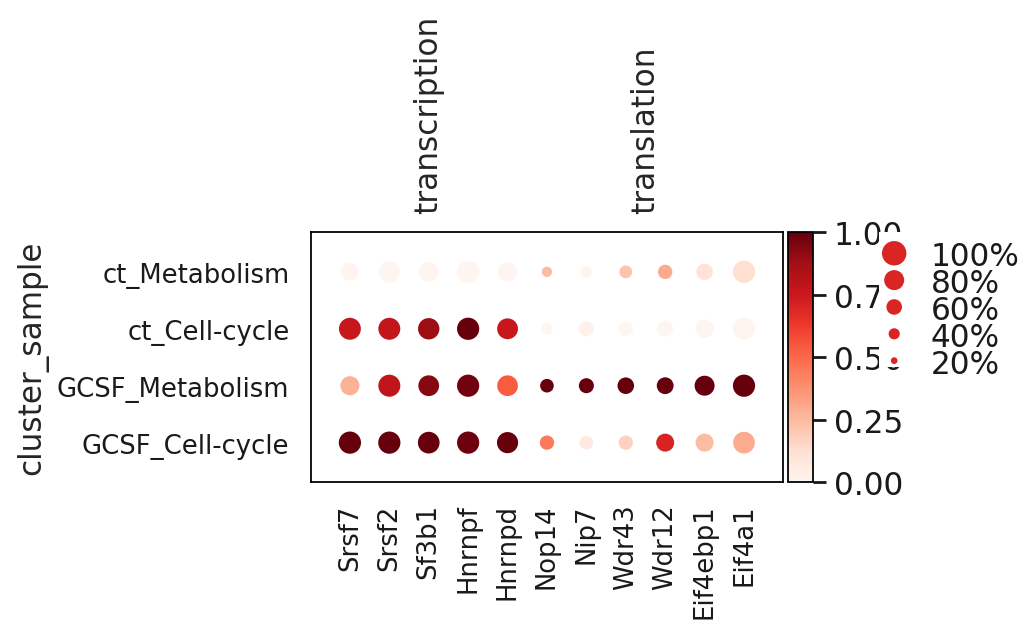

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[3.8499999999999996, 0, 0.2, 0.5, 0.25])

In [43]:
sc.pl.dotplot(adata[
                      
                      (adata.obs['cluster_sample']=='GCSF_Metabolism') | (adata.obs['cluster_sample']=='ct_Metabolism') |
                      (adata.obs['cluster_sample']=='ct_Cell-cycle') | (adata.obs['cluster_sample']=='GCSF_Cell-cycle')
                      ], 
                     GCSF_dic, groupby='cluster_sample', standard_scale = 'var', save='_LT_GCSF_new.pdf')

## indo

In [44]:
# Read files and check how many genes there are in HSCs for each cutoff

diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/indo_combo_HSCs_MPPs_nocutoff.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']
print('all differentially expressed genes')
print(len(diff_genes))

diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/indo_combo_HSCs_MPPs_1.2.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']
print('differentially expressed genes 1.2 fold')
print(len(diff_genes))

diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/indo_combo_HSCs_MPPs_1.5.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']
print('differentially expressed genes 1.5 fold')
print(len(diff_genes))

all differentially expressed genes
834
differentially expressed genes 1.2 fold
21
differentially expressed genes 1.5 fold
1


In [45]:
# choose 1.2 fold
diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/indo_combo_HSCs_MPPs_1.2.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']

# make dictonary from marker genes
indo_dict = diff_genes.groupby('specific')['primerid'].apply(list).to_dict()

# calculate average expression per cluster
indo_avg = average_expression(adata, indo_dict, gene_symbol_key=None, partition_key='cluster_sample')

In [46]:
# define categories and colors for plotting (make a look up table = lut)
lut = dict(zip(indo_avg['specific'].unique(), ["black", "lightgray"]))
row_colors = indo_avg['specific'].map(lut)

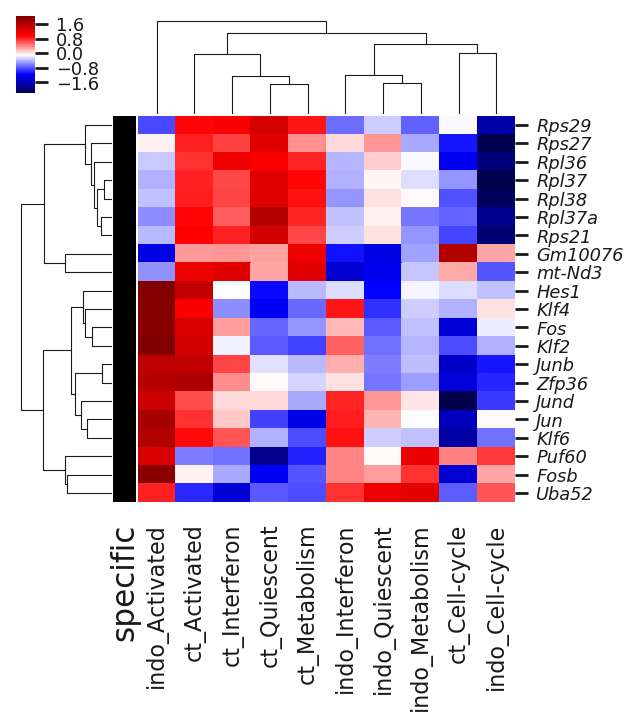

In [47]:
sns_plot = sns.clustermap(indo_avg[['ct_Activated','ct_Quiescent','ct_Metabolism', 'ct_Interferon','ct_Cell-cycle',
                                'indo_Activated','indo_Quiescent','indo_Metabolism', 'indo_Interferon', 'indo_Cell-cycle']],
                          col_cluster=True,
                          figsize= (4, 4),
                          z_score=0,
                          method= 'average',
                          metric = 'euclidean',
                          row_colors=row_colors,
                          yticklabels=True,
                          cmap = 'seismic')

plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=8) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 8, style ="italic")  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 10)  # For y axis

sns_plot.savefig("/home/jovyan/work/Z_TRASH/figures/indo_1.2_heatmap_all_genes.pdf", dpi=300)

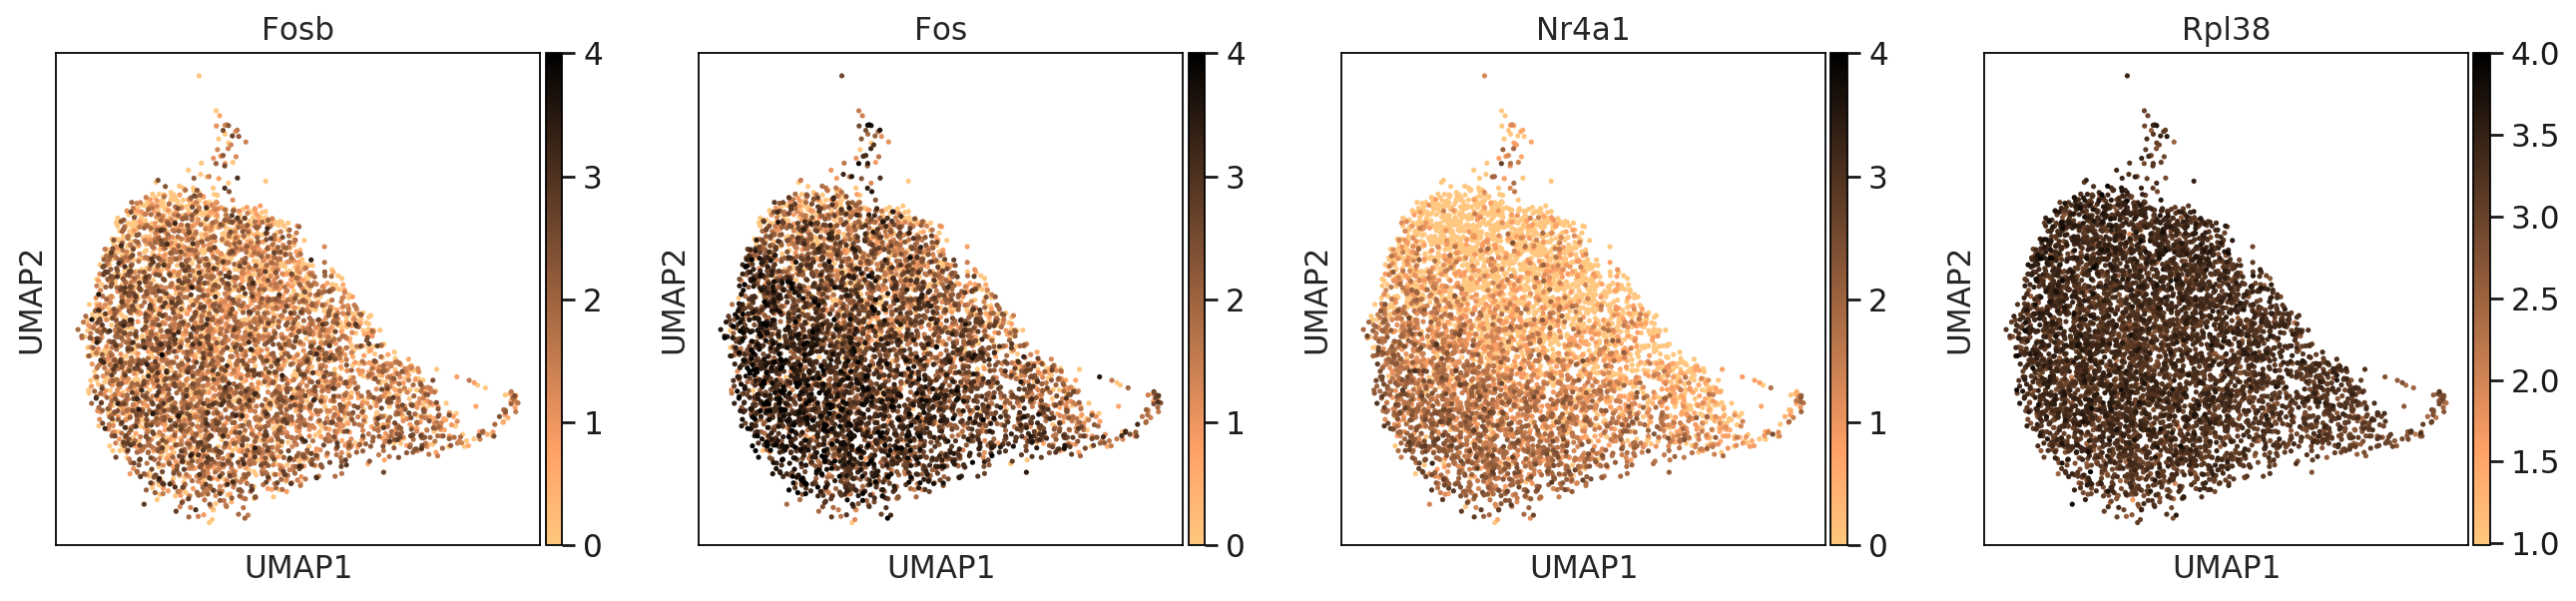

In [48]:
sc.pl.umap(adata[adata.obs['sample']=='ct'], color = ['Fosb', 'Fos', 'Nr4a1', 'Rpl38'], cmap ='copper_r', vmax=4)

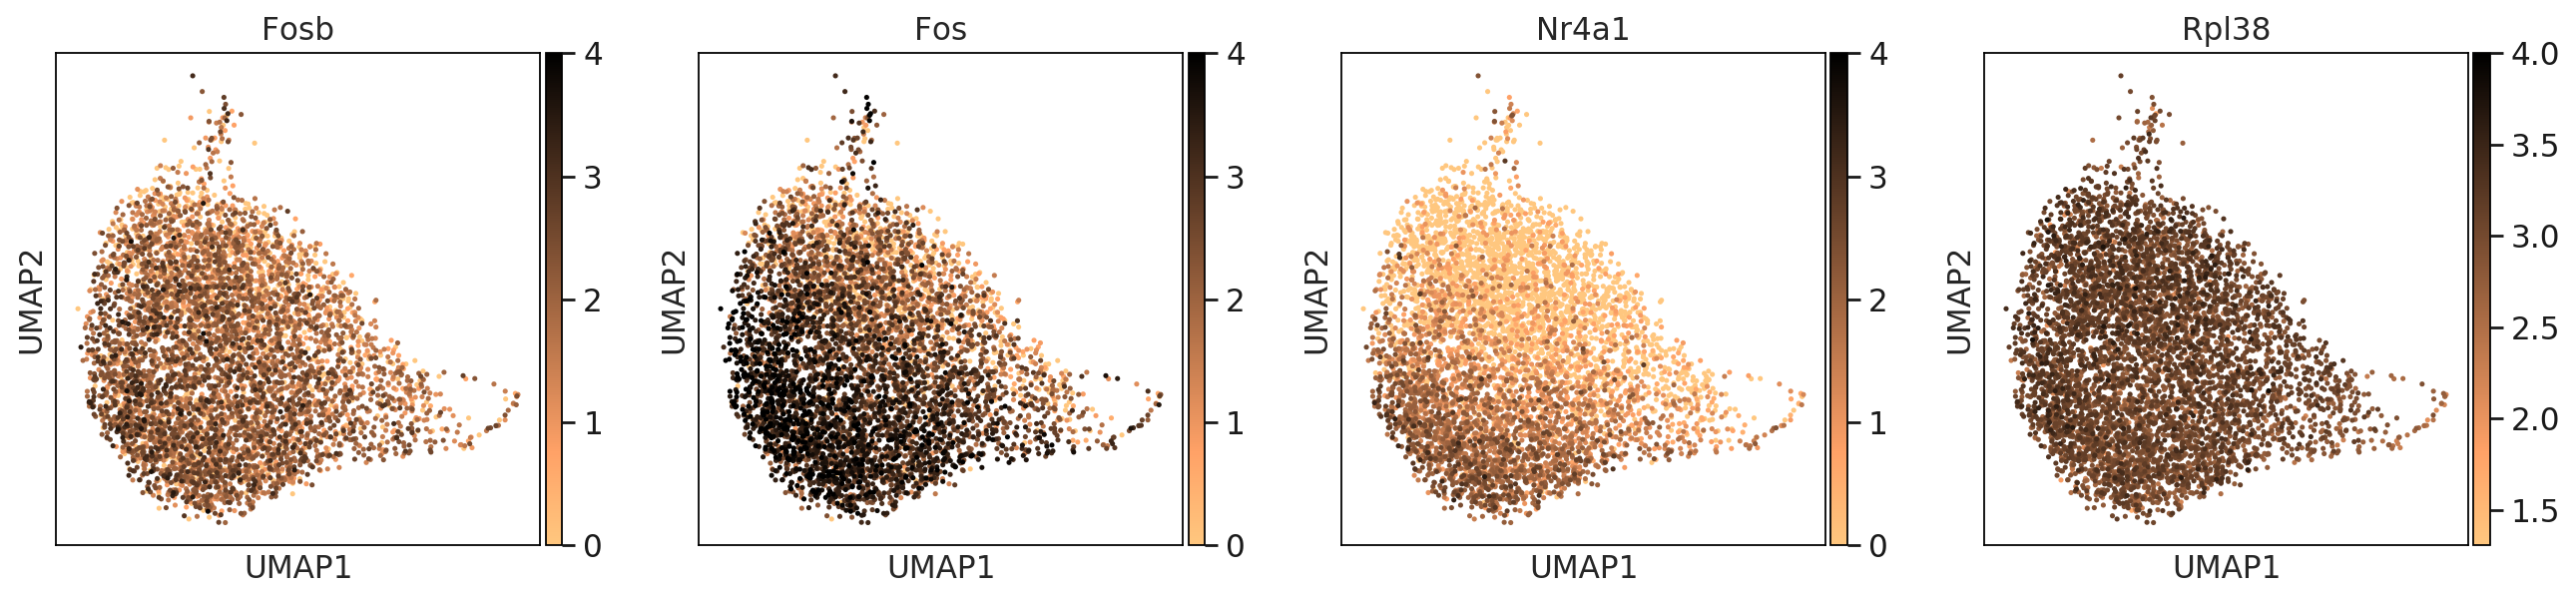

In [49]:
sc.pl.umap(adata[adata.obs['sample']=='indo'], color = ['Fosb', 'Fos', 'Nr4a1', 'Rpl38'], cmap ='copper_r', vmax=4)

## dmPGE2

In [50]:
# Read files and check how many genes there are in HSCs for each cutoff

diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/dmPGE2_combo_HSCs_MPPs_nocutoff.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']
print('all differentially expressed genes')
print(len(diff_genes))

diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/dmPGE2_combo_HSCs_MPPs_1.2.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']
print('differentially expressed genes 1.2 fold')
print(len(diff_genes))

diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/dmPGE2_combo_HSCs_MPPs_1.5.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']
print('differentially expressed genes 1.5 fold')
print(len(diff_genes))

all differentially expressed genes
3452
differentially expressed genes 1.2 fold
644
differentially expressed genes 1.5 fold
129


In [51]:
# choose 1.5 fold
diff_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/dmPGE2_combo_HSCs_MPPs_1.5.csv')
diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only']

# make dictonary from marker genes
dmPGE2_dict = diff_genes.groupby('specific')['primerid'].apply(list).to_dict()

# calculate average expression per cluster
dmPGE2_avg = average_expression(adata, dmPGE2_dict, gene_symbol_key=None, partition_key='cluster_sample')

In [52]:
# define categories and colors for plotting (make a look up table = lut)
lut = dict(zip(dmPGE2_avg['specific'].unique(), ["black", "lightgray"]))
row_colors = dmPGE2_avg['specific'].map(lut)

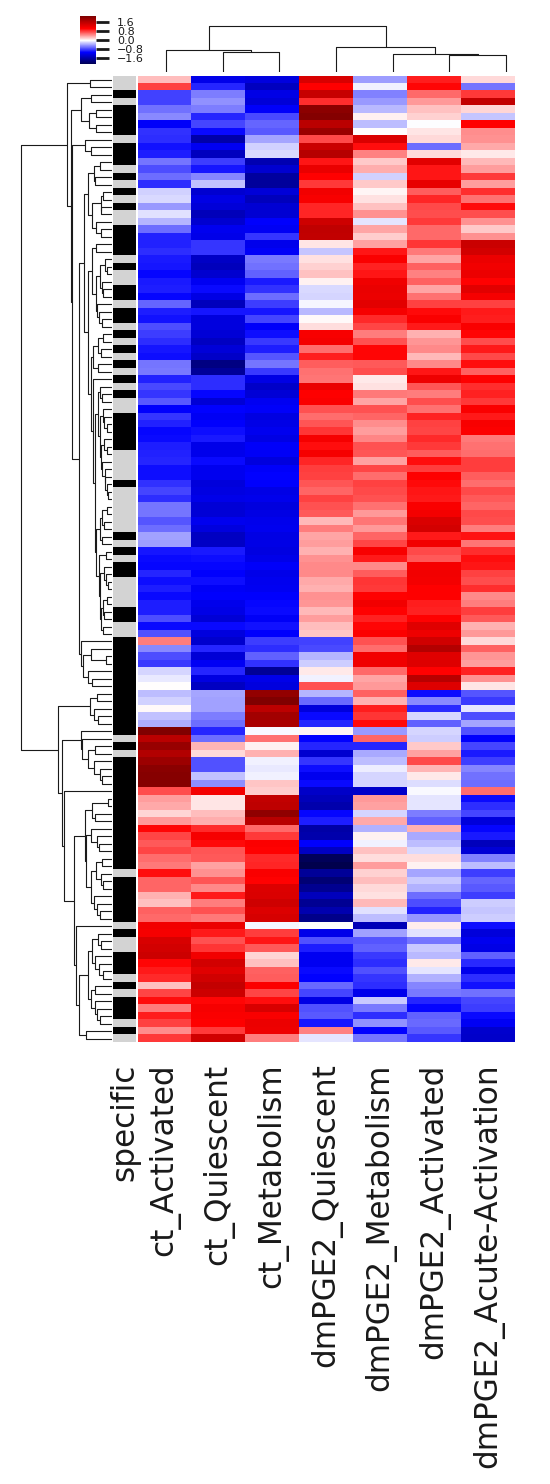

In [53]:
sns_plot = sns.clustermap(dmPGE2_avg[['ct_Activated','ct_Quiescent','ct_Metabolism', 
                                'dmPGE2_Activated','dmPGE2_Quiescent','dmPGE2_Metabolism', 'dmPGE2_Acute-Activation']],
                          col_cluster=True,
                          figsize= (4, 10),
                          z_score=0,
                          method= 'average',
                          row_colors=row_colors,
                          metric = 'euclidean',
                          cmap = 'seismic',
                          yticklabels=False)


ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_col_orig_pos.y0,
                                     0.62, 0.03])

sns_plot.cax.set_position([ax_col_orig_pos.x0 - 0.09, ax_col_orig_pos.y0 + 0.005, 
                                    .025, .03])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=5)
sns_plot.savefig("/home/jovyan/work/Z_TRASH/figures/dmPGE2_1.5_heatmap_all_genes_condensed.pdf", dpi=300)

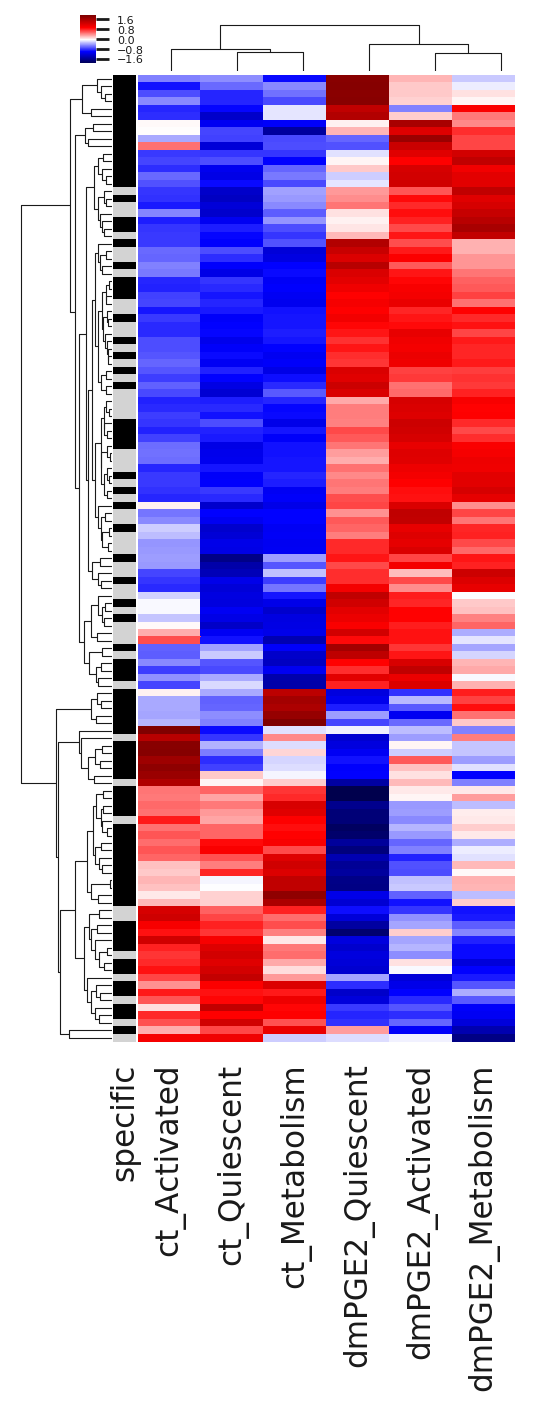

In [54]:
sns_plot = sns.clustermap(dmPGE2_avg[['ct_Activated','ct_Quiescent','ct_Metabolism', 
                                'dmPGE2_Activated','dmPGE2_Quiescent','dmPGE2_Metabolism']],
                          col_cluster=True,
                          figsize= (4, 10),
                          z_score=0,
                          method= 'average',
                          row_colors=row_colors,
                          metric = 'euclidean',
                          cmap = 'seismic',
                          yticklabels=False)


ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_col_orig_pos.y0,
                                     0.62, 0.03])

sns_plot.cax.set_position([ax_col_orig_pos.x0 - 0.09, ax_col_orig_pos.y0 + 0.005, 
                                    .025, .03])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=5)
sns_plot.savefig("/home/jovyan/work/Z_TRASH/figures/dmPGE2_1.5_heatmap_all_genes_condensed_no_AcuteA.pdf", dpi=300)

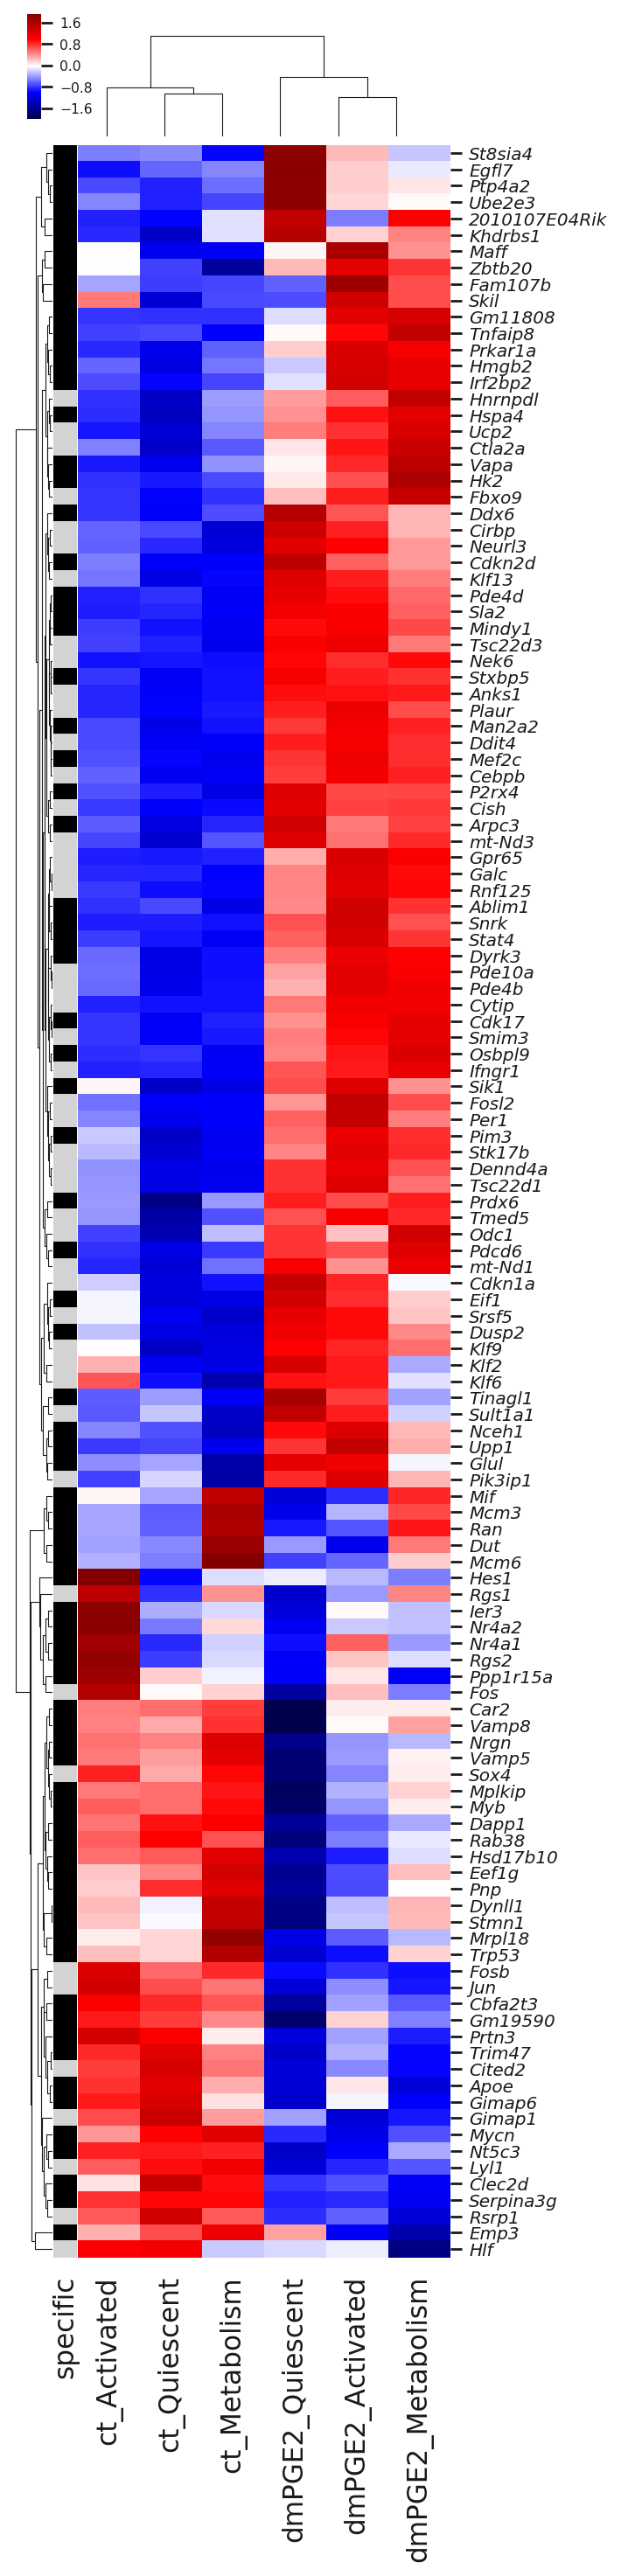

In [55]:
# larger - with gene names

sns_plot = sns.clustermap(dmPGE2_avg[['ct_Activated','ct_Quiescent','ct_Metabolism', 
                                'dmPGE2_Activated','dmPGE2_Quiescent','dmPGE2_Metabolism']],
                            cmap = 'seismic', 
                            figsize= (4, 25),
                            z_score=0,
                            center = 0,
                            row_colors=row_colors,
                            #annot=False, 
                            yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(True)
sns_plot.ax_col_dendrogram.set_visible(True)
#sns_plot.cax.set_visible(False)

ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_col_orig_pos.y0,
                                     0.62, 0.03])

sns_plot.cax.set_position([ax_col_orig_pos.x0 - 0.09, ax_col_orig_pos.y0 + 0.005, 
                                    .025, .03])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=7)



# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
#sns_plot.cax.set_position([1.1, .725, .03, .03])
#plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=10) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 9, style ="italic")  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 14)  # For y axis
sns_plot.savefig("/home/jovyan/work/Z_TRASH/figures/dmPGE2_1.5_heatmap_all_genes_long_no_AcuteA.pdf", dpi=300)

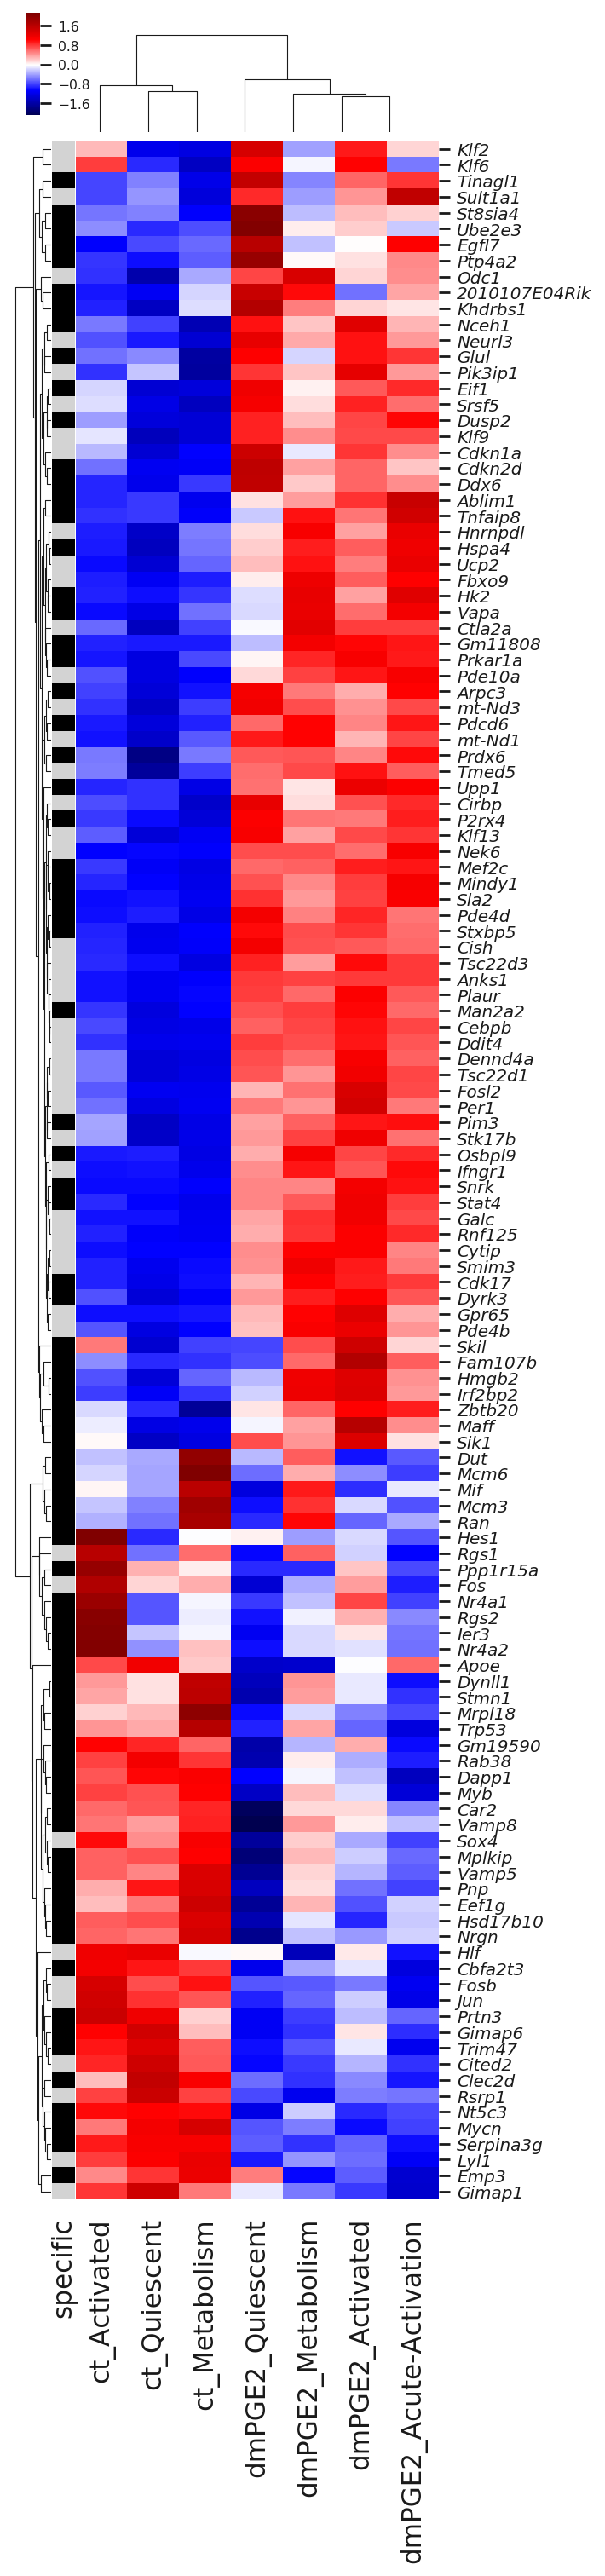

In [56]:
# larger - with gene names

sns_plot = sns.clustermap(dmPGE2_avg[['ct_Activated','ct_Quiescent','ct_Metabolism', 
                                'dmPGE2_Activated','dmPGE2_Quiescent','dmPGE2_Metabolism', 'dmPGE2_Acute-Activation']],
                            cmap = 'seismic', 
                            figsize= (4, 25),
                            z_score=0,
                            center = 0,
                            row_colors=row_colors,
                            #annot=False, 
                            yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(True)
sns_plot.ax_col_dendrogram.set_visible(True)
#sns_plot.cax.set_visible(False)

ax_col_orig_pos = sns_plot.ax_col_dendrogram.get_position()
sns_plot.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_col_orig_pos.y0,
                                     0.62, 0.03])

sns_plot.cax.set_position([ax_col_orig_pos.x0 - 0.09, ax_col_orig_pos.y0 + 0.005, 
                                    .025, .03])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=7)



# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
#sns_plot.cax.set_position([1.1, .725, .03, .03])
#plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=10) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 9, style ="italic")  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 14)  # For y axis
sns_plot.savefig("/home/jovyan/work/Z_TRASH/figures/dmPGE2_1.5_heatmap_all_genes_long.pdf", dpi=300)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


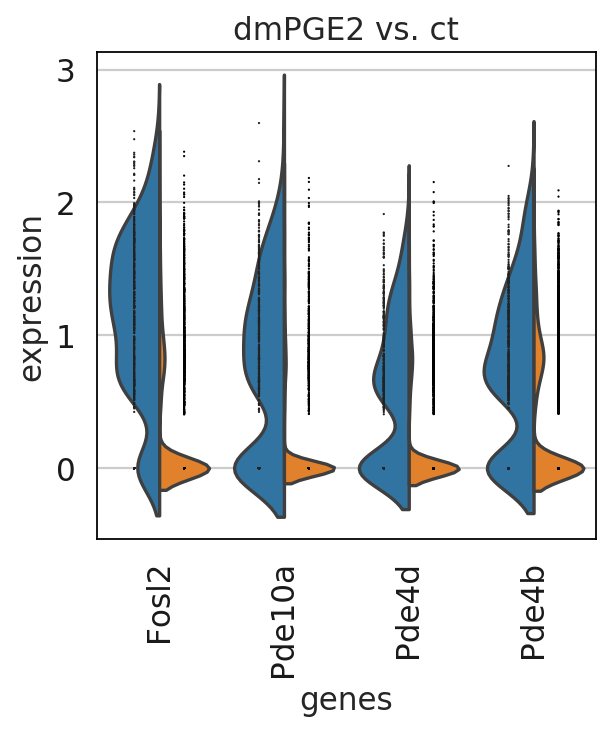

In [57]:
sc.tl.rank_genes_groups(adata, 'sample', groups = ['dmPGE2'], reference = 'ct', use_raw = True)
sc.pl.rank_genes_groups_violin(adata, groups=['dmPGE2'], gene_names=['Fosl2', 'Pde10a', 'Pde4d', 'Pde4b'], jitter = False, save='_LT_dmPGE2.pdf')

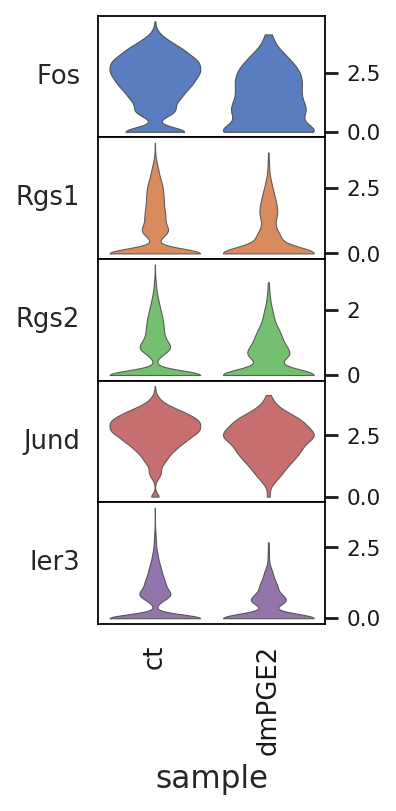

In [58]:
sc.pl.stacked_violin(adata[(adata.obs['sample']=='ct') |
                           (adata.obs['sample']=='dmPGE2') 
                           ],
                         ['Fos', 'Rgs1', 'Rgs2', 'Jund','Ier3'], figsize=(2,5), log=False, swap_axes=True, 
                          groupby='sample', save='_LT_dmPGE2_directionality.pdf')

## overlap conditions - cross talk betweem signatured

In [62]:
sample_name = ['dmPGE2', 'GCSF', 'indo', 'pIC']
results_df = pd.DataFrame()

for i in range(len(sample_name)):
        sample = sample_name[i] 

        path_name = '/home/jovyan/work/Z_TRASH/write/' + sample + '_combo_HSCs_MPPs_1.2.csv'
        df = pd.read_csv(path_name)
        
        df = df.set_index('primerid')

        #sample_id = sample + '_' + cluster    
        
        results_df = pd.merge(results_df, df, left_index=True, right_index=True, how='outer', suffixes=('', sample))

In [63]:
len(results_df)

2122

In [64]:
results_df

HSC_any  MPP_any  overlap  specific  HSC_anyGCSF  MPP_anyGCSF  \
primerid                                                                       
0610012G03Rik      NaN      NaN      NaN       NaN          NaN          NaN   
1110008F13Rik     -1.0      0.0      0.0  HSC_only          NaN          NaN   
1500009L16Rik      NaN      NaN      NaN       NaN          0.0         -1.0   
1600014C10Rik      NaN      NaN      NaN       NaN          NaN          NaN   
1700017B05Rik      1.0      1.0      1.0   overlap          NaN          NaN   
...                ...      ...      ...       ...          ...          ...   
mt-Nd2             1.0      1.0      1.0   overlap          0.0         -1.0   
mt-Nd3             1.0      1.0      1.0   overlap          0.0         -1.0   
mt-Nd4             1.0      0.0      0.0  HSC_only          0.0         -1.0   
mt-Nd4l            0.0      1.0      0.0  MPP_only          0.0          1.0   
mt-Nd5             1.0      0.0      0.0  HSC_only          NaN          NaN   

               overlapGCSF specificGCSF  HSC_anyindo  MPP_anyindo  \
primerid                                                            
0610012G03Rik          NaN          NaN          NaN          NaN   
1110008F13Rik          NaN          NaN          NaN          NaN   
1500009L16Rik          0.0     MPP_only          NaN          NaN   
1600014C10Rik          NaN          NaN          NaN          NaN   
1700017B05Rik          NaN          NaN          NaN          NaN   
...                    ...          ...          ...          ...   
mt-Nd2                 0.0     MPP_only          NaN          NaN   
mt-Nd3                 0.0     MPP_only         -1.0          0.0   
mt-Nd4                 0.0     MPP_only          NaN          NaN   
mt-Nd4l                0.0     MPP_only          NaN          NaN   
mt-Nd5                 NaN          NaN          NaN          NaN   

               overlapindo specificindo  HSC_anypIC  MPP_anypIC  overlappIC  \
primerid                                                                      
0610012G03Rik          NaN          NaN        -1.0         0.0         0.0   
1110008F13Rik          NaN          NaN        -1.0         0.0         0.0   
1500009L16Rik          NaN          NaN         NaN         NaN         NaN   
1600014C10Rik          NaN          NaN         0.0         1.0         0.0   
1700017B05Rik          NaN          NaN         NaN         NaN         NaN   
...                    ...          ...         ...         ...         ...   
mt-Nd2                 NaN          NaN         NaN         NaN         NaN   
mt-Nd3                 0.0     HSC_only         1.0         1.0         1.0   
mt-Nd4                 NaN          NaN         1.0         1.0         1.0   
mt-Nd4l                NaN          NaN         1.0         0.0         0.0   
mt-Nd5                 NaN          NaN         1.0         0.0         0.0   

              specificpIC  
primerid                   
0610012G03Rik    HSC_only  
1110008F13Rik    HSC_only  
1500009L16Rik         NaN  
1600014C10Rik    MPP_only  
1700017B05Rik         NaN  
...                   ...  
mt-Nd2                NaN  
mt-Nd3            overlap  
mt-Nd4            overlap  
mt-Nd4l          HSC_only  
mt-Nd5           HSC_only  

[2122 rows x 16 columns]

In [65]:
new_columns = ['HSC_any_dmPGE2',
                 'MPP_any_dmPGE2',
                 'overlap_dmPGE2',
                 'specific_dmPGE2',
                 'HSC_any_GCSF',
                 'MPP_any_GCSF',
                 'overlap_GCSF',
                 'specific_GCSF',
                 'HSC_any_indo',
                 'MPP_any_indo',
                 'overlap_indo',
                 'specific_indo',
                 'HSC_any_pIC',
                 'MPP_any_pIC',
                 'overlap_pIC',
                 'specific_pIC']

In [66]:
#rename columns
#input_df_bin.columns = new_columns
results_df.columns = new_columns

## three way comparison

In [67]:
condition_1 = 'HSC_any_dmPGE2' #dmPGE2
condition_2 = 'HSC_any_pIC' #Interferon
condition_3 = 'HSC_any_GCSF' #GCSF

In [68]:
results_df[(results_df[condition_1] > 0) & (results_df[condition_2] > 0) & (results_df[condition_3] > 0)]

HSC_any_dmPGE2  MPP_any_dmPGE2  overlap_dmPGE2 specific_dmPGE2  \
primerid                                                                   
Chmp4b               1.0             0.0             0.0        HSC_only   
Eif1                 1.0             1.0             1.0         overlap   
Glul                 1.0             1.0             1.0         overlap   
Hk2                  1.0             1.0             1.0         overlap   
Meg3                 1.0             1.0             1.0         overlap   
Rab18                1.0             0.0             0.0        HSC_only   
Snap23               1.0             1.0             1.0         overlap   
Stat3                1.0             0.0             0.0        HSC_only   
Sult1a1              1.0             1.0             1.0         overlap   
Tax1bp1              1.0             0.0             0.0        HSC_only   
Tgm2                 1.0             1.0             1.0         overlap   
Vmp1                 1.0             0.0             0.0        HSC_only   

          HSC_any_GCSF  MPP_any_GCSF  overlap_GCSF specific_GCSF  \
primerid                                                           
Chmp4b             1.0           1.0           1.0       overlap   
Eif1               1.0           1.0           1.0       overlap   
Glul               1.0           0.0           0.0      HSC_only   
Hk2                1.0           1.0           1.0       overlap   
Meg3               1.0           1.0           1.0       overlap   
Rab18              1.0           1.0           1.0       overlap   
Snap23             1.0           0.0           0.0      HSC_only   
Stat3              1.0           1.0           1.0       overlap   
Sult1a1            1.0           0.0           0.0      HSC_only   
Tax1bp1            1.0           0.0           0.0      HSC_only   
Tgm2               1.0           1.0           1.0       overlap   
Vmp1               1.0           1.0           1.0       overlap   

          HSC_any_indo  MPP_any_indo  overlap_indo specific_indo  HSC_any_pIC  \
primerid                                                                        
Chmp4b             NaN           NaN           NaN           NaN          1.0   
Eif1               NaN           NaN           NaN           NaN          1.0   
Glul               NaN           NaN           NaN           NaN          1.0   
Hk2                NaN           NaN           NaN           NaN          1.0   
Meg3               NaN           NaN           NaN           NaN          1.0   
Rab18              NaN           NaN           NaN           NaN          1.0   
Snap23             NaN           NaN           NaN           NaN          1.0   
Stat3              NaN           NaN           NaN           NaN          1.0   
Sult1a1            NaN           NaN           NaN           NaN          1.0   
Tax1bp1            NaN           NaN           NaN           NaN          1.0   
Tgm2               NaN           NaN           NaN           NaN          1.0   
Vmp1               NaN           NaN           NaN           NaN          1.0   

          MPP_any_pIC  overlap_pIC specific_pIC  
primerid                                         
Chmp4b            1.0          1.0      overlap  
Eif1              0.0          0.0     HSC_only  
Glul              0.0          0.0     HSC_only  
Hk2               0.0          0.0     HSC_only  
Meg3              0.0          0.0     HSC_only  
Rab18             0.0          0.0     HSC_only  
Snap23            0.0          0.0     HSC_only  
Stat3             1.0          1.0      overlap  
Sult1a1           0.0          0.0     HSC_only  
Tax1bp1           0.0          0.0     HSC_only  
Tgm2              0.0          0.0     HSC_only  
Vmp1              1.0          1.0      overlap

In [69]:
results_df[(results_df[condition_1] < 0) & (results_df[condition_2] < 0) & (results_df[condition_3] < 0)]

HSC_any_dmPGE2  MPP_any_dmPGE2  overlap_dmPGE2 specific_dmPGE2  \
primerid                                                                   
Atpif1              -1.0             0.0             0.0        HSC_only   
Coro1a              -1.0             0.0             0.0        HSC_only   
Dut                 -1.0             0.0             0.0        HSC_only   
Gimap1              -1.0            -1.0             1.0         overlap   
Gimap6              -1.0            -1.0             1.0         overlap   
Gm19590             -1.0            -1.0             1.0         overlap   
Hes1                -1.0             0.0             0.0        HSC_only   
Nr4a1               -1.0             0.0             0.0        HSC_only   
Nr4a2               -1.0             0.0             0.0        HSC_only   
Rgs2                -1.0             1.0            -1.0         overlap   
Stmn1               -1.0             0.0             0.0        HSC_only   
Tspan32             -1.0            -1.0             1.0         overlap   

          HSC_any_GCSF  MPP_any_GCSF  overlap_GCSF specific_GCSF  \
primerid                                                           
Atpif1            -1.0           0.0           0.0      HSC_only   
Coro1a            -1.0          -1.0           1.0       overlap   
Dut               -1.0           0.0           0.0      HSC_only   
Gimap1            -1.0          -1.0           1.0       overlap   
Gimap6            -1.0          -1.0           1.0       overlap   
Gm19590           -1.0          -1.0           1.0       overlap   
Hes1              -1.0          -1.0           1.0       overlap   
Nr4a1             -1.0          -1.0           1.0       overlap   
Nr4a2             -1.0          -1.0           1.0       overlap   
Rgs2              -1.0          -1.0           1.0       overlap   
Stmn1             -1.0          -1.0           1.0       overlap   
Tspan32           -1.0          -1.0           1.0       overlap   

          HSC_any_indo  MPP_any_indo  overlap_indo specific_indo  HSC_any_pIC  \
primerid                                                                        
Atpif1             NaN           NaN           NaN           NaN         -1.0   
Coro1a             NaN           NaN           NaN           NaN         -1.0   
Dut                NaN           NaN           NaN           NaN         -1.0   
Gimap1             NaN           NaN           NaN           NaN         -1.0   
Gimap6             NaN           NaN           NaN           NaN         -1.0   
Gm19590            NaN           NaN           NaN           NaN         -1.0   
Hes1               1.0           0.0           0.0      HSC_only         -1.0   
Nr4a1              NaN           NaN           NaN           NaN         -1.0   
Nr4a2              NaN           NaN           NaN           NaN         -1.0   
Rgs2               NaN           NaN           NaN           NaN         -1.0   
Stmn1              NaN           NaN           NaN           NaN         -1.0   
Tspan32            NaN           NaN           NaN           NaN         -1.0   

          MPP_any_pIC  overlap_pIC specific_pIC  
primerid                                         
Atpif1            0.0          0.0     HSC_only  
Coro1a           -1.0          1.0      overlap  
Dut              -1.0          1.0      overlap  
Gimap1            0.0          0.0     HSC_only  
Gimap6            0.0          0.0     HSC_only  
Gm19590          -1.0          1.0      overlap  
Hes1              0.0          0.0     HSC_only  
Nr4a1            -1.0          1.0      overlap  
Nr4a2            -1.0          1.0      overlap  
Rgs2              0.0          0.0     HSC_only  
Stmn1            -1.0          1.0      overlap  
Tspan32          -1.0          1.0      overlap

In [70]:
results_df[(results_df[condition_1] > 0) & (results_df[condition_2] > 0) & (results_df[condition_3] < 0)]

HSC_any_dmPGE2  MPP_any_dmPGE2  overlap_dmPGE2 specific_dmPGE2  \
primerid                                                                   
Cirbp                1.0             1.0             1.0         overlap   
Klf6                 1.0             1.0             1.0         overlap   
Klf9                 1.0             1.0             1.0         overlap   
Nceh1                1.0             1.0             1.0         overlap   
Neurl3               1.0             1.0             1.0         overlap   
Pnrc1                1.0             0.0             0.0        HSC_only   
Rps27                1.0             1.0             1.0         overlap   
Rps27rt              1.0             0.0             0.0        HSC_only   
Tsc22d3              1.0             1.0             1.0         overlap   
Txnip                1.0             1.0             1.0         overlap   

          HSC_any_GCSF  MPP_any_GCSF  overlap_GCSF specific_GCSF  \
primerid                                                           
Cirbp             -1.0          -1.0           1.0       overlap   
Klf6              -1.0          -1.0           1.0       overlap   
Klf9              -1.0           0.0           0.0      HSC_only   
Nceh1             -1.0           0.0           0.0      HSC_only   
Neurl3            -1.0          -1.0           1.0       overlap   
Pnrc1             -1.0          -1.0           1.0       overlap   
Rps27             -1.0          -1.0           1.0       overlap   
Rps27rt           -1.0           0.0           0.0      HSC_only   
Tsc22d3           -1.0          -1.0           1.0       overlap   
Txnip             -1.0          -1.0           1.0       overlap   

          HSC_any_indo  MPP_any_indo  overlap_indo specific_indo  HSC_any_pIC  \
primerid                                                                        
Cirbp              NaN           NaN           NaN           NaN          1.0   
Klf6               1.0           0.0           0.0      HSC_only          1.0   
Klf9               NaN           NaN           NaN           NaN          1.0   
Nceh1              NaN           NaN           NaN           NaN          1.0   
Neurl3             NaN           NaN           NaN           NaN          1.0   
Pnrc1              NaN           NaN           NaN           NaN          1.0   
Rps27             -1.0           0.0           0.0      HSC_only          1.0   
Rps27rt            NaN           NaN           NaN           NaN          1.0   
Tsc22d3            NaN           NaN           NaN           NaN          1.0   
Txnip              NaN           NaN           NaN           NaN          1.0   

          MPP_any_pIC  overlap_pIC specific_pIC  
primerid                                         
Cirbp             0.0          0.0     HSC_only  
Klf6              1.0          1.0      overlap  
Klf9              0.0          0.0     HSC_only  
Nceh1             1.0          1.0      overlap  
Neurl3            0.0          0.0     HSC_only  
Pnrc1             0.0          0.0     HSC_only  
Rps27             1.0          1.0      overlap  
Rps27rt           0.0          0.0     HSC_only  
Tsc22d3           0.0          0.0     HSC_only  
Txnip            -1.0         -1.0      overlap

In [71]:
results_df[(results_df[condition_1] < 0) & (results_df[condition_2] < 0) & (results_df[condition_3] > 0)]

HSC_any_dmPGE2  MPP_any_dmPGE2  overlap_dmPGE2 specific_dmPGE2  \
primerid                                                                   
Anp32b              -1.0             0.0             0.0        HSC_only   
Apex1               -1.0             0.0             0.0        HSC_only   
Atp5g1              -1.0             0.0             0.0        HSC_only   
C1qbp               -1.0             0.0             0.0        HSC_only   
Cct3                -1.0             0.0             0.0        HSC_only   
Cct8                -1.0             0.0             0.0        HSC_only   
Dkc1                -1.0             0.0             0.0        HSC_only   
Dynll1              -1.0            -1.0             1.0         overlap   
Gar1                -1.0             0.0             0.0        HSC_only   
Hsp90aa1            -1.0             0.0             0.0        HSC_only   
Hspa8               -1.0            -1.0             1.0         overlap   
Hspd1               -1.0             0.0             0.0        HSC_only   
Mif                 -1.0            -1.0             1.0         overlap   
Mrpl12              -1.0             0.0             0.0        HSC_only   
Myb                 -1.0            -1.0             1.0         overlap   
Nhp2                -1.0             0.0             0.0        HSC_only   
Nme1                -1.0             0.0             0.0        HSC_only   
Nop10               -1.0             0.0             0.0        HSC_only   
Nop56               -1.0            -1.0             1.0         overlap   
Ppp1r14b            -1.0             0.0             0.0        HSC_only   
Prtn3               -1.0            -1.0             1.0         overlap   
Psma7               -1.0             0.0             0.0        HSC_only   
Psmb5               -1.0             0.0             0.0        HSC_only   
Psmb6               -1.0             0.0             0.0        HSC_only   
Psmd7               -1.0             0.0             0.0        HSC_only   
Ran                 -1.0             0.0             0.0        HSC_only   
Ranbp1              -1.0             0.0             0.0        HSC_only   
Rexo2               -1.0             0.0             0.0        HSC_only   
Slc25a5             -1.0             0.0             0.0        HSC_only   
Snrpd1              -1.0             0.0             0.0        HSC_only   
Srm                 -1.0             0.0             0.0        HSC_only   

          HSC_any_GCSF  MPP_any_GCSF  overlap_GCSF specific_GCSF  \
primerid                                                           
Anp32b             1.0           1.0           1.0       overlap   
Apex1              1.0           1.0           1.0       overlap   
Atp5g1             1.0           1.0           1.0       overlap   
C1qbp              1.0           1.0           1.0       overlap   
Cct3               1.0           1.0           1.0       overlap   
Cct8               1.0           1.0           1.0       overlap   
Dkc1               1.0           1.0           1.0       overlap   
Dynll1             1.0           1.0           1.0       overlap   
Gar1               1.0           1.0           1.0       overlap   
Hsp90aa1           1.0           1.0           1.0       overlap   
Hspa8              1.0           1.0           1.0       overlap   
Hspd1              1.0           1.0           1.0       overlap   
Mif                1.0           1.0           1.0       overlap   
Mrpl12             1.0           1.0           1.0       overlap   
Myb                1.0           1.0           1.0       overlap   
Nhp2               1.0           1.0           1.0       overlap   
Nme1               1.0           1.0           1.0       overlap   
Nop10              1.0           1.0           1.0       overlap   
Nop56              1.0           1.0           1.0       overlap   
Ppp1r14b           1.0           1.0           1.0       overlap   
Prtn3

In [72]:
results_df[(results_df[condition_1] < 0) & (results_df[condition_2] > 0) & (results_df[condition_3] > 0)]

HSC_any_dmPGE2  MPP_any_dmPGE2  overlap_dmPGE2 specific_dmPGE2  \
primerid                                                                    
Fut8                 -1.0            -1.0             1.0         overlap   
Ifitm1               -1.0            -1.0             1.0         overlap   
Serpina3g            -1.0            -1.0             1.0         overlap   

           HSC_any_GCSF  MPP_any_GCSF  overlap_GCSF specific_GCSF  \
primerid                                                            
Fut8                1.0           1.0           1.0       overlap   
Ifitm1              1.0           1.0           1.0       overlap   
Serpina3g           1.0           1.0           1.0       overlap   

           HSC_any_indo  MPP_any_indo  overlap_indo specific_indo  \
primerid                                                            
Fut8                NaN           NaN           NaN           NaN   
Ifitm1              NaN           NaN           NaN           NaN   
Serpina3g           NaN           NaN           NaN           NaN   

           HSC_any_pIC  MPP_any_pIC  overlap_pIC specific_pIC  
primerid                                                       
Fut8               1.0          1.0          1.0      overlap  
Ifitm1             1.0          1.0          1.0      overlap  
Serpina3g          1.0          1.0          1.0      overlap

In [73]:
results_df[(results_df[condition_1] > 0) & (results_df[condition_2] < 0) & (results_df[condition_3] < 0)]

HSC_any_dmPGE2  MPP_any_dmPGE2  overlap_dmPGE2 specific_dmPGE2  \
primerid                                                                   
Hmgb2                1.0             1.0             1.0         overlap   
Klf2                 1.0             1.0             1.0         overlap   
Myct1                1.0             1.0             1.0         overlap   
Pik3ip1              1.0             1.0             1.0         overlap   

          HSC_any_GCSF  MPP_any_GCSF  overlap_GCSF specific_GCSF  \
primerid                                                           
Hmgb2             -1.0          -1.0           1.0       overlap   
Klf2              -1.0          -1.0           1.0       overlap   
Myct1             -1.0          -1.0           1.0       overlap   
Pik3ip1           -1.0          -1.0           1.0       overlap   

          HSC_any_indo  MPP_any_indo  overlap_indo specific_indo  HSC_any_pIC  \
primerid                                                                        
Hmgb2              NaN           NaN           NaN           NaN         -1.0   
Klf2               1.0           0.0           0.0      HSC_only         -1.0   
Myct1              NaN           NaN           NaN           NaN         -1.0   
Pik3ip1            NaN           NaN           NaN           NaN         -1.0   

          MPP_any_pIC  overlap_pIC specific_pIC  
primerid                                         
Hmgb2            -1.0          1.0      overlap  
Klf2              0.0          0.0     HSC_only  
Myct1             0.0          0.0     HSC_only  
Pik3ip1           0.0          0.0     HSC_only

In [74]:
results_df[(results_df[condition_1] > 0) & (results_df[condition_2] < 0) & (results_df[condition_3] > 0)]

HSC_any_dmPGE2  MPP_any_dmPGE2  overlap_dmPGE2 specific_dmPGE2  \
primerid                                                                   
Hnrnpf               1.0             0.0             0.0        HSC_only   

          HSC_any_GCSF  MPP_any_GCSF  overlap_GCSF specific_GCSF  \
primerid                                                           
Hnrnpf             1.0           1.0           1.0       overlap   

          HSC_any_indo  MPP_any_indo  overlap_indo specific_indo  HSC_any_pIC  \
primerid                                                                        
Hnrnpf             NaN           NaN           NaN           NaN         -1.0   

          MPP_any_pIC  overlap_pIC specific_pIC  
primerid                                         
Hnrnpf            0.0          0.0     HSC_only

In [75]:
results_df[(results_df[condition_1] < 0) & (results_df[condition_2] > 0) & (results_df[condition_3] < 0)]

HSC_any_dmPGE2  MPP_any_dmPGE2  overlap_dmPGE2 specific_dmPGE2  \
primerid                                                                   
Cited2              -1.0            -1.0             1.0         overlap   
Clec2d              -1.0            -1.0             1.0         overlap   
Egr1                -1.0             0.0             0.0        HSC_only   
Fos                 -1.0             1.0            -1.0         overlap   
Fosb                -1.0            -1.0             1.0         overlap   
Jun                 -1.0            -1.0             1.0         overlap   

          HSC_any_GCSF  MPP_any_GCSF  overlap_GCSF specific_GCSF  \
primerid                                                           
Cited2            -1.0          -1.0           1.0       overlap   
Clec2d            -1.0          -1.0           1.0       overlap   
Egr1              -1.0          -1.0           1.0       overlap   
Fos               -1.0          -1.0           1.0       overlap   
Fosb              -1.0          -1.0           1.0       overlap   
Jun               -1.0          -1.0           1.0       overlap   

          HSC_any_indo  MPP_any_indo  overlap_indo specific_indo  HSC_any_pIC  \
primerid                                                                        
Cited2             NaN           NaN           NaN           NaN          1.0   
Clec2d             NaN           NaN           NaN           NaN          1.0   
Egr1               NaN           NaN           NaN           NaN          1.0   
Fos                1.0           0.0           0.0      HSC_only          1.0   
Fosb               1.0           0.0           0.0      HSC_only          1.0   
Jun                1.0           0.0           0.0      HSC_only          1.0   

          MPP_any_pIC  overlap_pIC specific_pIC  
primerid                                         
Cited2            1.0          1.0      overlap  
Clec2d            1.0          1.0      overlap  
Egr1              0.0          0.0     HSC_only  
Fos               1.0          1.0      overlap  
Fosb              1.0          1.0      overlap  
Jun               1.0          1.0      overlap

## Comparison pIC and GCSF

In [76]:
up_pIC = results_df[(results_df[condition_2] > 0) & (results_df[condition_3] < 0)].index.tolist()

In [77]:
sources = ['REAC']

pathway_enrich_genes(up_pIC, sources)

name  \
native                                                                      
REAC:R-MMU-450341  Activation of the AP-1 family of transcription factors   
REAC:R-MMU-450282    MAPK targets/ Nuclear events mediated by MAP kinases   
REAC:R-MMU-168179                    Toll Like Receptor TLR1:TLR2 Cascade   
REAC:R-MMU-181438                     Toll Like Receptor 2 (TLR2) Cascade   
REAC:R-MMU-168142                   Toll Like Receptor 10 (TLR10) Cascade   
REAC:R-MMU-448424                                Interleukin-17 signaling   
REAC:R-MMU-450294                                   MAP kinase activation   
REAC:R-MMU-975871              MyD88 cascade initiated on plasma membrane   
REAC:R-MMU-168176                     Toll Like Receptor 5 (TLR5) Cascade   
REAC:R-MMU-168164                     Toll Like Receptor 3 (TLR3) Cascade   

                    p_value  term_size    recall intersections  
native                                                          
REAC:R-MMU-450341  0.004965          9  0.222222    [Fos, Jun]  
REAC:R-MMU-450282  0.023906         27  0.074074    [Fos, Jun]  
REAC:R-MMU-168179  0.025868         68  0.029412    [Fos, Jun]  
REAC:R-MMU-181438  0.025868         68  0.029412    [Fos, Jun]  
REAC:R-MMU-168142  0.025868         68  0.029412    [Fos, Jun]  
REAC:R-MMU-448424  0.025868         56  0.035714    [Fos, Jun]  
REAC:R-MMU-450294  0.025868         56  0.035714    [Fos, Jun]  
REAC:R-MMU-975871  0.025868         68  0.029412    [Fos, Jun]  
REAC:R-MMU-168176  0.025868         68  0.029412    [Fos, Jun]  
REAC:R-MMU-168164  0.025868         69  0.028986    [Fos, Jun]

In [78]:
gene_name_annotation_long(up_pIC)

incoming  \
0      Ccl4   
1     Cirbp   
2    Cited2   
3    Clec2d   
4     Dusp1   
5      Egr1   
6       Fos   
7      Fosb   
8     Foxp1   
9    H2-T23   
10     Irf1   
11      Jun   
12     Junb   
13     Klf6   
14     Klf9   
15     Lst1   
16    Nceh1   
17   Neurl3   
18    Pnrc1   
19    Rps27   
20    Rps27   
21  Rps27rt   
22    Rps29   
23  Tsc22d3   
24    Txnip   
25    Zfp36   

                                                                     short_description  
0                                                      chemokine (C-C motif) ligand 4   
1                                                  cold inducible RNA binding protein   
2   Cbp/p300-interacting transactivator, with Glu/Asp-rich carboxy-terminal domain, 2   
3                                             C-type lectin domain family 2, member d   
4                                                      dual specificity phosphatase 1   
5                                                             early growth response 1   
6                                                           FBJ osteosarcoma oncogene   
7                                                         FBJ osteosarcoma oncogene B   
8                                                                     forkhead box P1   
9                                             histocompatibility 2, T region locus 23   
10                                                     interferon regulatory factor 1   
11                                                                 jun proto-oncogene   
12                                                               jun B proto-oncogene   
13                                                              Kruppel-like factor 6   
14                                                              Kruppel-like factor 9   
15                                                    leukocyte specific transcript 1   
16                                              neutral cholesterol ester hydrolase 1   
17                                           neuralized E3 ubiquitin protein ligase 3   
18                                        proline-rich nuclear receptor coactivator 1   
19                                                   ribosomal protein S27, retrogene   
20                                                              ribosomal protein S27   
21                                                   ribosomal protein S27, retrogene   
22                                                              ribosomal protein S29   
23                                                      TSC22 domain family, member 3   
24                                                    thioredoxin interacting protein   
25                                                             zinc finger protein 36

In [79]:
down_pIC = results_df[(results_df[condition_2] < 0) & (results_df[condition_3] > 0)].index.tolist()

In [80]:
sources = ['GO:BP']

pathway_enrich_genes(down_pIC, sources)

name  \
native                                                                                    
GO:0032200                                                        telomere organization   
GO:0000723                                                         telomere maintenance   
GO:0007004                                          telomere maintenance via telomerase   
GO:0006278                                       RNA-dependent DNA biosynthetic process   
GO:0044237                                                   cellular metabolic process   
GO:0006807                                          nitrogen compound metabolic process   
GO:0034641                                 cellular nitrogen compound metabolic process   
GO:0010833                                telomere maintenance via telomere lengthening   
GO:1904816  positive regulation of protein localization to chromosome, telomeric region   
GO:0008152                                                            metabolic process   

                 p_value  term_size    recall  \
native                                          
GO:0032200  3.041120e-09        130  0.076923   
GO:0000723  3.041120e-09        128  0.078125   
GO:0007004  7.060131e-09         67  0.119403   
GO:0006278  7.060131e-09         68  0.117647   
GO:0044237  7.060131e-09      10446  0.005169   
GO:0006807  1.736211e-08       9785  0.005314   
GO:0034641  1.736211e-08       6187  0.006788   
GO:0010833  1.919138e-08         82  0.097561   
GO:1904816  4.380419e-08         13  0.384615   
GO:0008152  8.050557e-08      11640  0.004725   

                                                                                                                                                                                                                                                                                                                                                                                             intersections  
native                                                                                                                                                                                                                                                                                                                                                                                                      
GO:0032200                                                                                                                                                                                                                                                                                                                              [Apex1, Cct3, Cct8, Dkc1, Gar1, Gnl3, Hsp90aa1, Nhp2, Nop10, Tcp1]  
GO:0000723                                                                                                                                                                                                                                                                                                                              [Apex1, Cct3, Cct8, Dkc1, Gar1, Gnl3, Hsp90aa1, Nhp2, Nop10, Tcp1]  
GO:0007004                                                                                                                                                                                                                                                                                                                                           [Cct3, Cct8, Dkc1, Gar1, Hsp90aa1, Nhp2, Nop10, Tcp1]  
GO:0006278                                                                                                                                                                                                                                                                                                                                           [Cct3, Cct8, Dkc1, Gar1, Hsp90aa1, Nhp2, Nop10, Tcp1]  
GO:0044237         

In [81]:
gene_name_annotation_long(down_pIC)

incoming  \
0     Alyref   
1     Anp32b   
2      Apex1   
3       Aprt   
4     Atp5g1   
5      C1qbp   
6     Cacybp   
7       Cct3   
8       Cct8   
9       Cope   
10     Cox5a   
11      Dkc1   
12    Dynll1   
13    Eif4a1   
14  Eif4ebp1   
15     Eif5a   
16      Eprs   
17     Fubp1   
18      Gar1   
19      Gnl3   
20      Hdgf   
21   Hnrnpab   
22    Hnrnpf   
23    Hnrnpu   
24    Hnrnpu   
25  Hsp90aa1   
26   Hsp90b1   
27     Hspa8   
28     Hspd1   
29      Ldha   
30      Manf   
31       Mif   
32    Mrpl12   
33       Myb   
34       Ncl   
35      Nhp2   
36      Nme1   
37     Nop10   
38     Nop56   
39  Ppp1r14b   
40     Prmt1   
41     Prtn3   
42     Psma7   
43     Psmb5   
44     Psmb6   
45     Psmc5   
46     Psmd7   
47       Ran   
48    Ranbp1   
49    Ranbp1   
50     Rexo2   
51    Sec61b   
52       Set   
53   Slc25a5   
54    Snrpd1   
55       Srm   
56     Srsf2   
57      Tcp1   
58     Tmed2   
59    Tubb4b   
60     U2af1   
61      Ubtf   
62     Wdr12   
63      Ybx3   

                                                                               short_description  
0                                                                         Aly/REF export factor   
1                              acidic (leucine-rich) nuclear phosphoprotein 32 family, member B   
2                                                          apurinic/apyrimidinic endonuclease 1   
3                                                            adenine phosphoribosyl transferase   
4               ATP synthase, H+ transporting, mitochondrial F0 complex, subunit C1 (subunit 9)   
5                                        complement component 1, q subcomponent binding protein   
6                                                                     calcyclin binding protein   
7                                                 chaperonin containing Tcp1, subunit 3 (gamma)   
8                                                 chaperonin containing Tcp1, subunit 8 (theta)   
9                                                     coatomer protein complex, subunit epsilon   
10                                                              cytochrome c oxidase subunit 5A   
11                                                           dyskeratosis congenita 1, dyskerin   
12                                                                dynein light chain LC8-type 1   
13                                                 eukaryotic translation initiation factor 4A1   
14                                eukaryotic translation initiation factor 4E binding protein 1   
15                                                  eukaryotic translation initiation factor 5A   
16                                                              glutamyl-prolyl-tRNA synthetase   
17                                                far upstream element (FUSE) binding protein 1   
18                                                                       GAR1 ribonucleoprotein   
19                                        guanine nucleotide binding protein-like 3 (nucleolar)   
20                                                                heparin binding growth factor   
21                                                  heterogeneous nuclear ribonucleoprotein A/B   
22                                                    heterogeneous nuclear ribonucleoprotein F   
23                                                    heterogeneous nuclear ribonucleoprotein U   
24                                                    heterogeneous nuclear ribonucleoprotein U   
25                                   heat shock protein 90, alpha (cytosolic), class A member 1   
26                                                heat shock protein 90, beta (Grp94), member 1   
27                                                                         heat shock protein 8   
28                                                            heat shock protein 1 (chaperon

In [82]:
# Order of the lineage
lin = ( 'GCSF_Quiescent', 'ct_Quiescent', 'pIC_Quiescent', 'GCSF_Activated', 'ct_Activated', 
       'pIC_Activated', 'GCSF_Interferon','GCSF_Metabolism', 'GCSF_Cell-cycle', 'ct_Interferon', 
       'ct_Metabolism', 'ct_Cell-cycle',
    
       
       'indo_Activated', 'indo_Quiescent', 'indo_Metabolism', 'indo_Cell-cycle', 'indo_Interferon', 
       'indo_Acute-Activation',
       'dmPGE2_Activated', 'dmPGE2_Quiescent', 'dmPGE2_Metabolism', 'dmPGE2_Acute-Activation',
         'pIC_Interferon', 'pIC_Metabolism', 'pIC_Cell-cycle'
       
       )

# Reordering leiden labels using Categorical data type
adata.obs['cluster_sample'] = adata.obs['cluster_sample'].cat.reorder_categories((lin), ordered=True)

In [83]:
# define list of what genes to show

pIC_GCSF = {'fetal hematopoiesis': ['Psmb5', "Psmb6", 'Psma7','Cct3', 'Cct8'],
            'heat shock': ['Hspd1', 'Hsp90aa1', 'Hsp90ab1', 'Hspa8'],
            'telomere complex':['Gar1', 'Nhp2', 'Nop10', 'Dkc1'],
            'translation initiation': ['Eif5a', 'Eif4a1', 'Eif4ebp1', 'Eif4a2', 'Eif4ebp2'],
            }

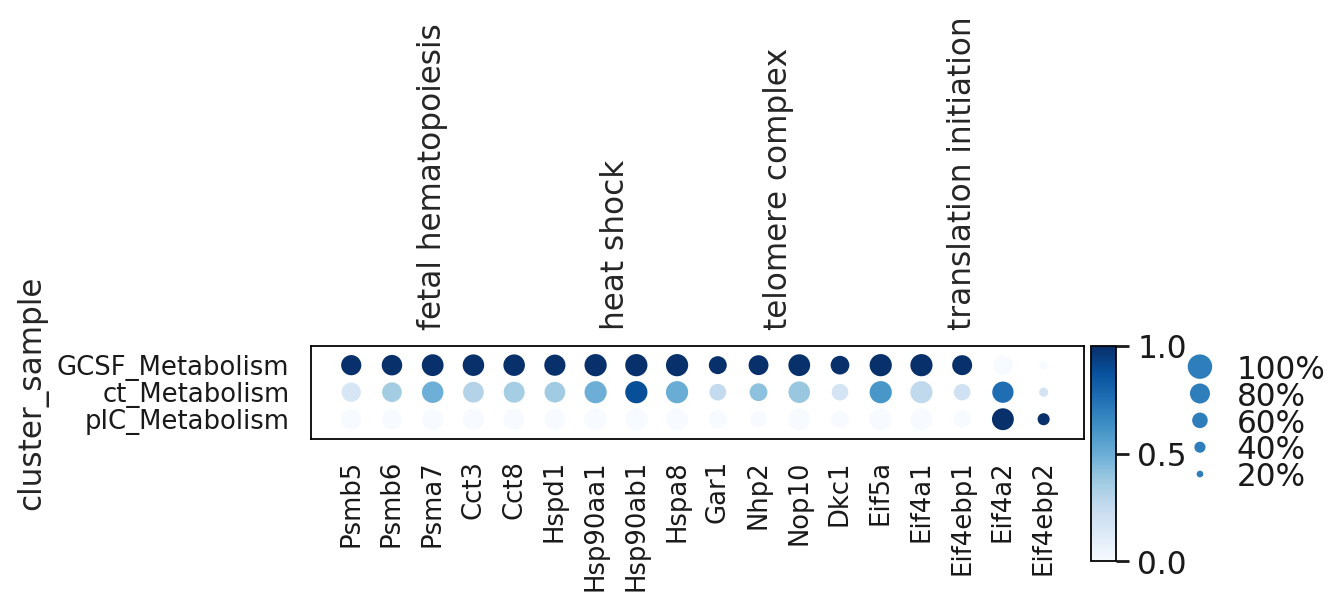

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[6.3, 0, 0.2, 0.5, 0.25])

In [84]:
sc.pl.dotplot(adata[(adata.obs['cluster_sample']=='GCSF_Metabolism') | (adata.obs['cluster_sample']=='ct_Metabolism') |
                    (adata.obs['cluster_sample']=='pIC_Metabolism')
                      ], 
                     pIC_GCSF, groupby='cluster_sample', color_map='Blues', save='_LT_pIC_GCSF_crosstalk.pdf', 
              standard_scale = 'var')

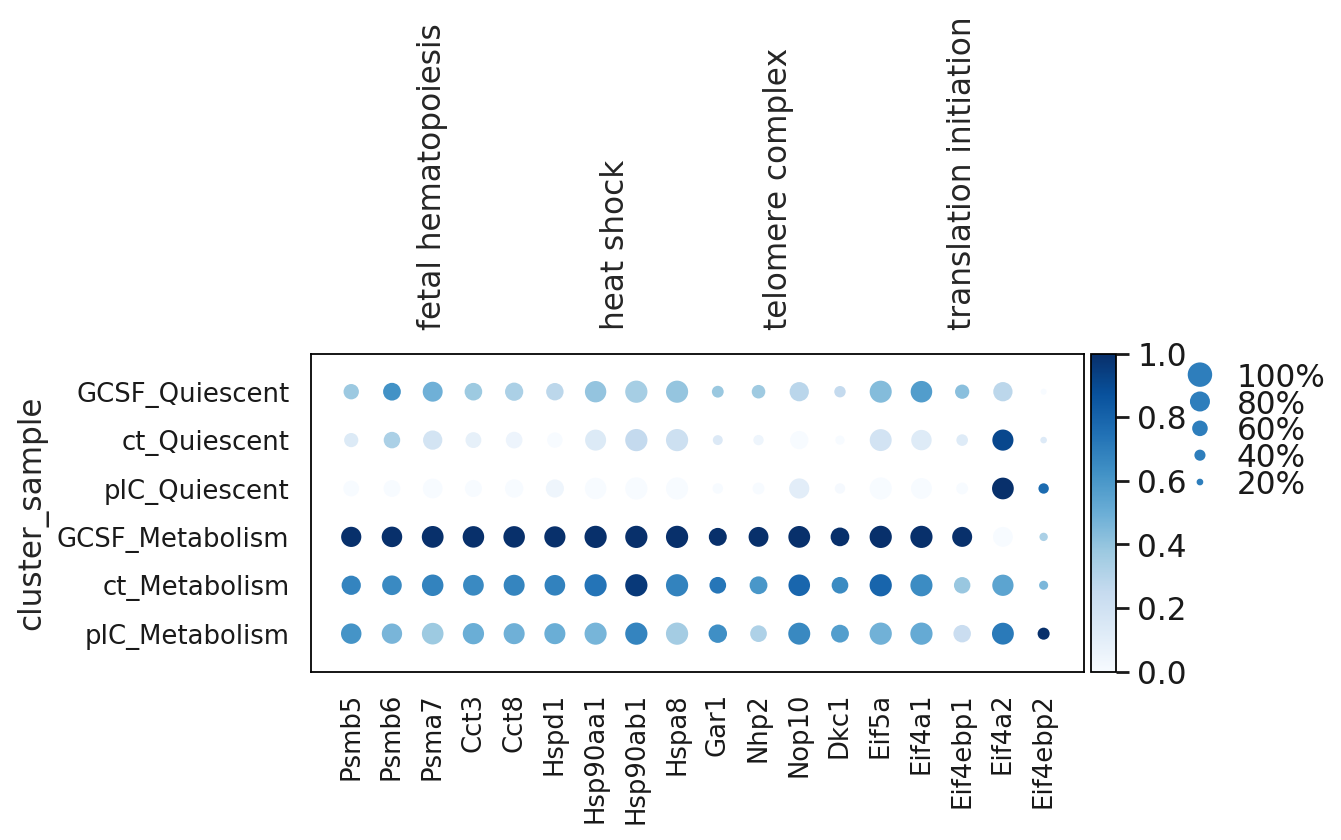

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[6.3, 0, 0.2, 0.5, 0.25])

In [85]:
sc.pl.dotplot(adata[(adata.obs['cluster_sample']=='GCSF_Metabolism') | (adata.obs['cluster_sample']=='ct_Metabolism') |
                    (adata.obs['cluster_sample']=='pIC_Metabolism') |
                    (adata.obs['cluster_sample']=='GCSF_Quiescent') | (adata.obs['cluster_sample']=='ct_Quiescent') |
                    (adata.obs['cluster_sample']=='pIC_Quiescent')
                      ], 
                     pIC_GCSF, groupby='cluster_sample', color_map='Blues', save='_LT_pIC_GCSF_crosstalk_expanded.pdf', 
              standard_scale = 'var')

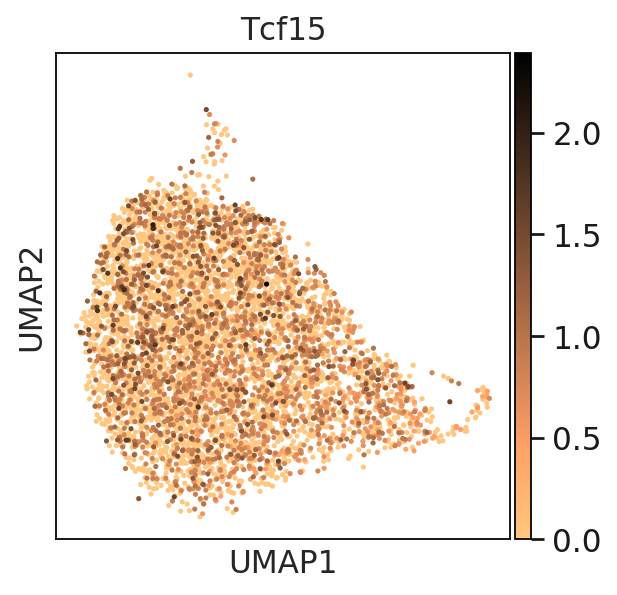

In [86]:
sc.pl.umap(adata[adata.obs['sample']=='ct'], color = ['Tcf15'], cmap ='copper_r')

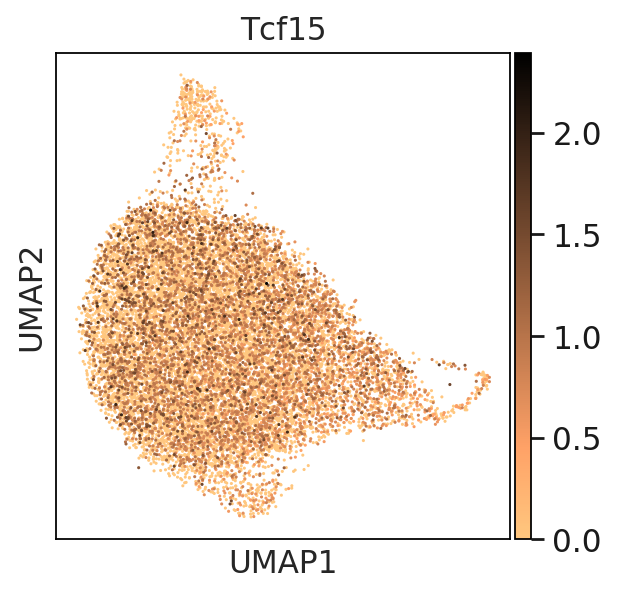

In [87]:
sc.pl.umap(adata, color = ['Tcf15'], cmap ='copper_r')

In [88]:
%pip list

Package                Version            
---------------------- -------------------
alembic                1.3.0              
anndata                0.7.1              
async-generator        1.10               
attrs                  19.3.0             
backcall               0.1.0              
beautifulsoup4         4.8.1              
bleach                 3.1.0              
blinker                1.4                
bokeh                  1.3.4              
cellbrowser            0.7.7              
certifi                2020.4.5.1         
certipy                0.1.3              
cffi                   1.13.2             
chardet                3.0.4              
Click                  7.0                
cloudpickle            1.2.2              
conda                  4.7.12             
conda-package-handling 1.6.0              
cryptography           2.8                
cycler                 0.10.0             
Cython                 0.29.14            
cytoolz    

In [89]:
sc.logging.print_versions()
pd.show_versions()

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.17.3 scipy==1.3.1 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.6.1

INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.4.39-linuxkit
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 0.25.3
numpy            : 1.17.3
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 41.6.0.post20191101
Cython           : 0.29.14
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.9.0
pand